### Imports

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import statistics
from datetime import datetime
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
from IPython.display import display

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from ucimlrepo import fetch_ucirepo 



### Distância de Minkowski

In [3]:
def calculateDist(p1, p2, n):
    return ((abs(p1[0] - p2[0])**n) + (abs(p1[1] - p2[1])**n)) ** (1/n)

* __Distância Manhattan__ __->__  n = 1

* __Distância Euclidiana__ __->__  n = 2


In [4]:
def calculateDistances(pontos, n):
    distances = [[] for _ in range(len(pontos))]
    for i, p1 in enumerate(pontos):
        for j, p2 in enumerate(pontos):
            distances[i].append(calculateDist(p1, p2, n))
    return distances

### Função para vizualização

Para pontos em duas dimensões

In [5]:
def plotClusters2D(clusters,n):
    
    plt.figure(figsize=(8, 8))
    colors = plt.get_cmap('Set1', len(clusters))  
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i + 1}')
        
        #Centro do cluster
        center = np.array(cluster[0])
        plt.scatter(center[0], center[1], color='black', marker='x')
        
        #Raio
        max_dist = max([calculateDist(center,p,n) for p in cluster])
        circle = plt.Circle(center, max_dist, color=colors(i), fill=False, linestyle='--')
        plt.gca().add_patch(circle)
        plt.text(center[0], center[1] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Clusters')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


Para pontos em três dimensões

In [6]:
def plotClusters3D(clusters, n):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.get_cmap('tab20b', len(clusters))
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], color=colors(i), label=f'Cluster {i + 1}')
        
        # Centro do cluster
        center = np.mean(cluster_points, axis=0)
        ax.scatter(center[0], center[1], center[2], color='black', marker='x')
        
        # Raio
        max_dist = max([calculateDist(center, p, n) for p in cluster])
        
        #Nesse caso temos uma esfera e não circulo
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = max_dist * np.cos(u) * np.sin(v) + center[0]
        y = max_dist * np.sin(u) * np.sin(v) + center[1]
        z = max_dist * np.cos(v) + center[2]
        
        ax.plot_surface(x, y, z, color=colors(i), alpha=0.3, edgecolor='none')
        ax.text(center[0], center[1], center[2] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Clusters')
    ax.legend()
    plt.show()

Para várias dimensões a vizualização em gráficos fica inviável

In [7]:
def printClusters(clusters,n):
    
    print(f"Clusters encontrados: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}:")
        print(f"Pontos: {cluster}")
        max_dist = max([calculateDist(cluster[0], p,2) for p in cluster])
        print(f"Raio do Cluster: {max_dist}")

Função auxiliar 

In [8]:
def get_labels(clusters, pontos):
    labels = [-1] * len(pontos)  # Initialize labels with -1 for safety
    point_to_label = {}

    # Create a mapping from each point to its cluster label
    for cluster_index, cluster in enumerate(clusters):
        for point in cluster:
            point_to_label[tuple(point)] = cluster_index

    # Assign labels to the original points based on the mapping
    for i, point in enumerate(pontos):
        labels[i] = point_to_label[tuple(point)]
        
    return labels

### Primeira versão do algoritmo 2-aproximado

Nessa versão  o intervalo para o raio ótimo é refinado até uma largura definida. Primeiramente vamos definir funções auxiliares para conseguir fazer o algoritmo:

In [9]:
#Função responsável por determinar se é possível dado um conjunto de pontos achar k clusters de raio maximo 2 rmax

def findSolution(pontos, rmax, k,n):
    success = False
    solution = []
    clusters = []
    pts = pontos[:]
    
    while len(pts) > 0:
        current_p = pts.pop(0)
        solution.append(current_p)
        cluster = [current_p]
        
        pts_to_remove = []
        for p in pts:
            if calculateDist(current_p, p, n) < 2 * rmax:
                cluster.append(p)
                pts_to_remove.append(p)
        
        for p in pts_to_remove:
            pts.remove(p)
        
        clusters.append(cluster)
    
    if len(solution) <= k:
        success = True
    
    return success, clusters


Agora podemos ir para a implementação do algoritmo em si:

In [10]:
def k_clustering(pontos,porcentagem_largura,k_clusters,n_distancia,distMatrix,true_labels):
    limite_superior = max(max(row) for row in distMatrix)
    limite_inferior = 0
    
    largura_total = limite_superior - limite_inferior 
    
    raio = limite_superior/2
    
    success = False
    
    while not(success) or ((limite_superior-limite_inferior) >= (porcentagem_largura*largura_total)):
        success, clusters = findSolution(pontos, raio, k_clusters,n_distancia)
        if success:
            limite_superior = raio
            raio = limite_superior/2
        else:
            limite_inferior = raio
            raio = raio + raio/2
    
            
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)
    
    labels = get_labels(clusters, pontos)
        
    if len(set(labels)) > 1:  # Verifica se há mais de um cluster
        sil_score = silhouette_score(pontos, labels)
    else:
        sil_score = 0  # Define como 0 ou outro valor padrão quando há apenas um cluster
    
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari
    

### Segunda versão do algoritmo 2-aproximado

Nessa os centros são escolhidos para maximizar a distância entre os centros previamente escolhidos

In [11]:
#Calcula o ponto com a máxima distância mínima aos pontos em centers
def mostDistant(pontos, centers, n, distMatrix):
    maxDist = 0
    for p in pontos:
        if p not in centers:
            minDist = np.inf
            for c in centers:
                dist = distMatrix[pontos.index(p)][pontos.index(c)]
                if dist < minDist:
                    minDist = dist
            if minDist > maxDist:
                maxDist = minDist
                p_choice = p
    return p_choice

#Determina os centros dos clusters
def getCenters(pontos,k_clusters,n,distMatrix):
    if k_clusters >= len(pontos):
        return pontos
    
    centers = [pontos[0]]
    while (len(centers) < k_clusters):
        s = mostDistant(pontos, centers, n, distMatrix)
        centers.append(s)
    return centers

#Determina o centro mais próximo do ponto p
def find_closest_center(pontos, centers, p, n, distMatrix):
    minDist = np.inf
    for c in centers:
        dist = distMatrix[pontos.index(p)][pontos.index(c)]
        if dist < minDist:
            minDist = dist
            closest_center = c
    return closest_center

#Determina os clusters por meio da maximização dos centros já escolhidos
def makeClusters(pontos, k_clusters, n, distMatrix, true_labels):
    centers = getCenters(pontos, k_clusters, n, distMatrix)
    clusters = [[c] for c in centers] # inicializa os clusters apenas com o centro
    for p in pontos:
        closest_center = find_closest_center(pontos, centers, p, n, distMatrix)
        clusters[centers.index(closest_center)].append(p)
    # calcula o raio de cada cluster
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)

    labels = get_labels(clusters, pontos)
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari


### Kmeans

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

def performKmeans(pontos, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(pontos)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(labels):
        clusters[label].append(pontos[i])

    for i in range(n_clusters):
        clusters[i] = np.array(clusters[i])
    
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)

    radii = []
    centroids = kmeans.cluster_centers_
    for i in range(kmeans.n_clusters):
        # Get points in the cluster
        cluster_points = clusters[i]
        
        # Calculate distances from the centroid
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        
        # Get the maximum distance as the radius
        radius = np.max(distances)
        radii.append(radius)

    return clusters, radii, sil_score, ari


## Dados

### Carregamento dos dados reais

Foi feito todo um pre-processamento para conseguir esses csvs

In [15]:
df_hepatitis = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/hepatitis.csv')
df_raisin = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/raisin.csv')
df_mice_protein = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/mice_protein.csv')
df_yeast = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/yeast.csv')
df_maternal_risk = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/maternal_risk.csv')
df_credit = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/credit.csv')
df_adult = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/adult.csv')
df_diabetic_retinopathy = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/diabetic_retinopathy.csv')
df_dry_beans = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/dry_beans.csv')
df_wine_quality = pd.read_csv('/home/diogo/Documents/ALG2/data/reais/wine_quality.csv')

real_datasets = [df_hepatitis, df_raisin, df_mice_protein, df_yeast, df_maternal_risk, df_credit, df_adult, df_diabetic_retinopathy, df_dry_beans, df_wine_quality]

In [16]:
from os import name
labels_list_real = [[] for _ in range(10)]
dada_real = [[] for _ in range(10)]
qt_clusters_real = []
for i, df in enumerate(real_datasets):
    labels_list_real[i].append(df['Label'].values)
    dada_real[i].append(df[df.columns[:-1]].values)
    qt_clusters_real.append(len(df['Label'].unique()))


names_models_real = ['hepatitis', 'raisin', 'mice_protein', 'yeast', 'maternal_risk', 'credit', 'adult', 'diabetic_retinopathy', 'dry_beans','wine_quality']

### Geração de datasets sintéticos

##### Normal multivariada

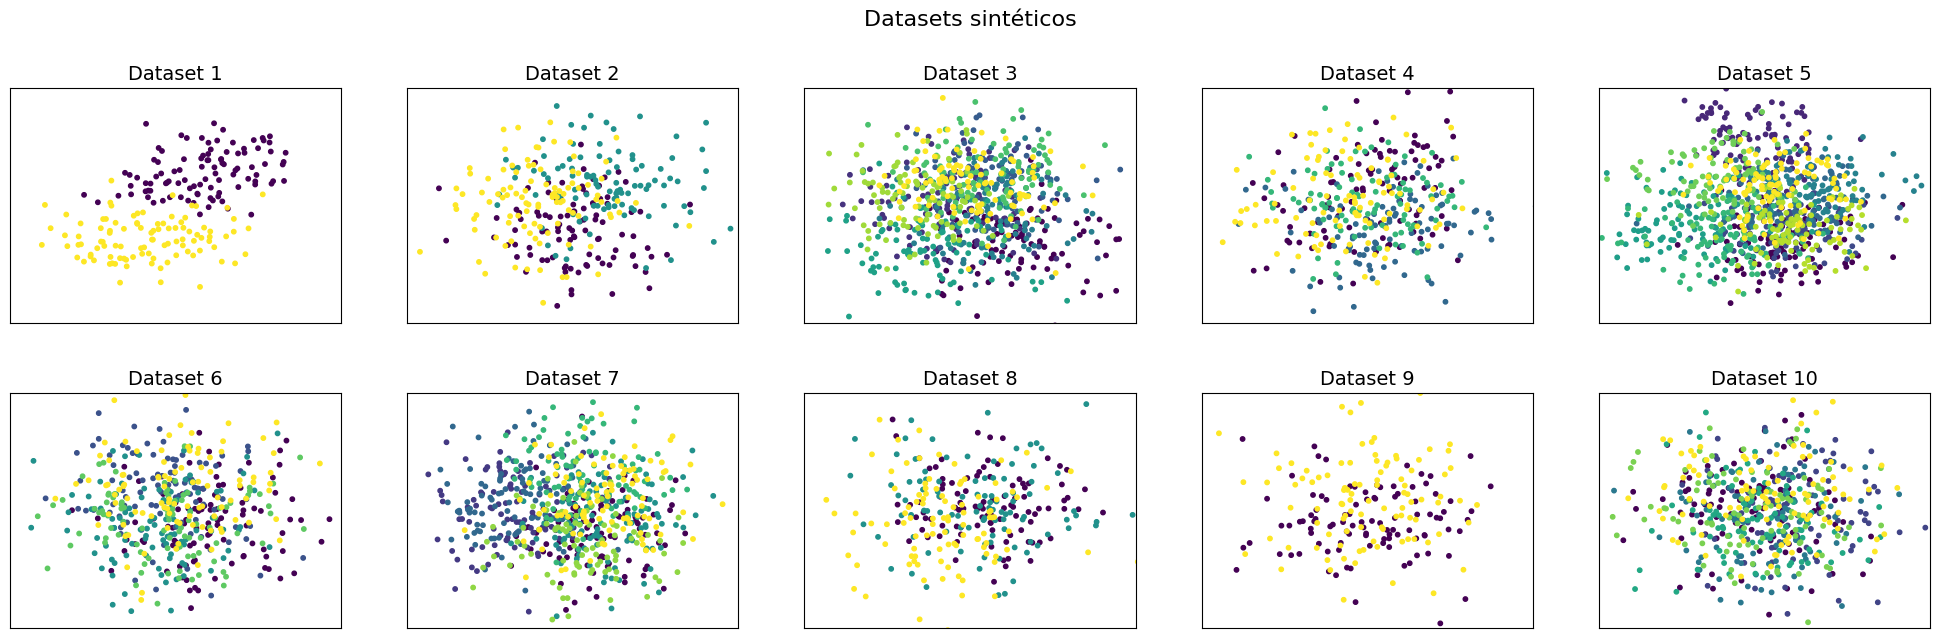

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def generate_random_coordinates(x):
    coordinates = np.random.rand(x, 2)
    return coordinates

def generateSyntheticDataWithLabels(centers, std_dev, num_points_per_center):
    pontos = []
    labels = []
    
    for idx, center in enumerate(centers):
        cov_matrix = [[std_dev**2, 0], [0, std_dev**2]]
        points = np.random.multivariate_normal(mean=center, cov=cov_matrix, size=num_points_per_center)
        pontos.append(points)
        labels.extend([idx] * num_points_per_center)  # Assign label idx to each point
    
    return np.vstack(pontos), np.array(labels)

def apply_standard_scaling(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Parameters for synthetic data generation
n_clusters_normal = [2, 3, 8, 4, 10, 5, 7, 3, 2, 6]  # Número de clusters variado
std_devs = [0.1, 0.5, 0.3, 1.0, 0.2, 0.7, 0.4, 1.5, 0.6, 0.9]  # Desvios padrão variáveis

base_num_points = 100
num_points_per_center = [int(base_num_points) for std_dev in std_devs]

data_normal = []
labels_list_normal = []
for i in range(10):
    centers = generate_random_coordinates(n_clusters_normal[i])
    dataset, labels = generateSyntheticDataWithLabels(centers, std_devs[i], num_points_per_center[i])
    scaled_dataset = apply_standard_scaling(dataset)
    data_normal.append(scaled_dataset)
    labels_list_normal.append(labels)

# Plotting
n_rows = 2
n_cols = 5
plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.92, wspace=0.2, hspace=0.3)

for i in range(10):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(f"Dataset {i+1}", size=14)
    plt.scatter(data_normal[i][:, 0], data_normal[i][:, 1], c=labels_list_normal[i], s=10, cmap='viridis')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xticks(())
    plt.yticks(())

plt.suptitle("Datasets sintéticos", size=16, y=1.05)
plt.show()

##### Exemplos scikit learn

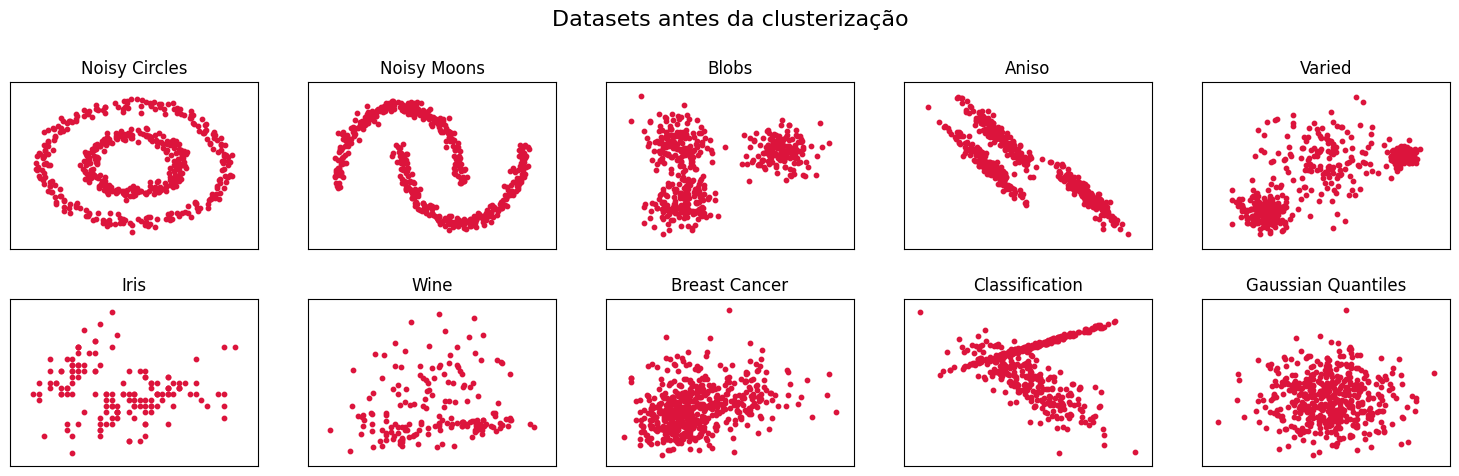

In [18]:
# Load original datasets
noisy_circles = datasets.make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=30) #2 labels
noisy_moons = datasets.make_moons(n_samples=500, noise=0.05, random_state=30) #2 labels
blobs = datasets.make_blobs(n_samples=500, random_state=30) #3 labels

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=500, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)#3 labels

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=170)#3 labels

# Load new datasets
iris = datasets.load_iris(return_X_y=True)#3 labels
wine = datasets.load_wine(return_X_y=True)#3 labels
breast_cancer = datasets.load_breast_cancer(return_X_y=True) #2 labels
classification = datasets.make_classification(
    n_samples=500, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2, 
    n_clusters_per_class=1, 
    random_state=42
)
gaussian_quantiles = datasets.make_gaussian_quantiles(n_samples=500, n_features=2, n_classes=2, random_state=42) #2 labels

# List of datasets and titles
datasets_list_sklearn = [
    noisy_circles, noisy_moons, blobs,
    aniso, varied, iris, wine, breast_cancer, classification, gaussian_quantiles
]
dataset_titles_sklearn = [
    'Noisy Circles', 'Noisy Moons', 'Blobs',
    'Aniso', 'Varied', 'Iris', 'Wine', 'Breast Cancer','Classification', 'Gaussian Quantiles'
]

k_clusters_sklearn = [
    2,2,3,3,3,3,3,2,2,2
    ]

# Plot settings
n_cols = 5
n_rows = 2
fig_size = (4 * n_cols * 0.8, 3 * n_rows * 0.8)
plt.figure(figsize=fig_size)
plt.subplots_adjust(
    left=0.05, right=0.95, bottom=0.05, top=0.85, wspace=0.2, hspace=0.3
)

plt.suptitle('Datasets antes da clusterização', size=16, y=1.0)

for i, (dataset, title) in enumerate(zip(datasets_list_sklearn, dataset_titles_sklearn)):
    if len(dataset) == 2:
        X, _ = dataset  # For datasets that return X and y
    else:
        X, _ = dataset
    X = StandardScaler().fit_transform(X)
    
    plt.subplot(n_rows, n_cols, i + 1)
    plt.title(title, size=12)
    
    plt.scatter(X[:, 0], X[:, 1], s=10, color="crimson")
    plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    plt.xticks(())
    plt.yticks(())

plt.show()

## Testes

In [19]:
def executeAll(data, k_clusters, n_distance, labels, nome_test, n_experimentos=30):
    pontos = data.tolist()
    distMatrix = calculateDistances(pontos, n_distance)

    # Armazenar resultados do Algoritmo 1
    resultados = []

    percentages = np.linspace(0.14, 0.25, num=5)
    
    for percentage in percentages:
        percentage = np.around(percentage, decimals=3)
        dur_alg1 = []
        max_rai_alg1 = []
        mean_rai_alg1 = []
        sil_alg1 = []
        ra_alg1 = []
        for _ in range(n_experimentos):
            # Algoritmo 1
            #print(percentage)

            start_time = datetime.now()
            clusters_1, raios_1, sil_1, r_1 = k_clustering(pontos, percentage, k_clusters, n_distance, distMatrix, labels)
            end_time = datetime.now()
            duration = (end_time - start_time).total_seconds() * 1000

            dur_alg1.append(duration)
            raios_1 = [sublista[0] for sublista in raios_1]
            max_rai_alg1.append(max(raios_1))
            mean_rai_alg1.append(statistics.mean(raios_1))
            sil_alg1.append(sil_1)
            ra_alg1.append(r_1)

        # Calculando médias para o Algoritmo 1
        mean_dur_alg1 = round(np.mean(dur_alg1), 4)
        mean_max_rai_alg1 = round(np.mean(max_rai_alg1), 4)
        mean_mean_rai_alg1 = round(np.mean(mean_rai_alg1), 4)
        mean_sil_alg1 = round(np.mean(sil_alg1), 4)
        mean_ra_alg1 = round(np.mean(ra_alg1), 4)

        # Adicionando resultados à lista
        resultados.append({
            'Modelo': f"Algoritmo 1 com intervalo {percentage}",
            'Duração Algoritmo (ms)': mean_dur_alg1,
            'Maior Raio': mean_max_rai_alg1,
            'Média Raios': mean_mean_rai_alg1,
            'Silhueta': mean_sil_alg1,
            'Índice de Rand Ajustado': mean_ra_alg1,
        })

    # Inicializar listas para o Algoritmo 2
    dur_alg2 = []
    max_rai_alg2 = []
    mean_rai_alg2 = []
    sil_alg2 = []
    ra_alg2 = []

    # Executando Algoritmo 2 30 vezes
    for _ in range(n_experimentos):
        start_time = datetime.now()
        clusters_2, raios_2, sil_2, r_2 = makeClusters(pontos, k_clusters, n_distance, distMatrix, labels)
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds() * 1000

        dur_alg2.append(duration)
        raios_2 = [sublista[0] for sublista in raios_2]
        max_rai_alg2.append(max(raios_2))
        mean_rai_alg2.append(statistics.mean(raios_2))
        sil_alg2.append(sil_2)
        ra_alg2.append(r_2)

    # Calculando médias para o Algoritmo 2
    mean_dur_alg2 = round(np.mean(dur_alg2), 4)
    mean_max_rai_alg2 = round(np.mean(max_rai_alg2), 4)
    mean_mean_rai_alg2 = round(np.mean(mean_rai_alg2), 4)
    mean_sil_alg2 = round(np.mean(sil_alg2), 4)
    mean_ra_alg2 = round(np.mean(ra_alg2), 4)

    resultados.append({
        'Modelo': "Algoritmo 2",
        'Duração Algoritmo (ms)': mean_dur_alg2,
        'Maior Raio': mean_max_rai_alg2,
        'Média Raios': mean_mean_rai_alg2,
        'Silhueta': mean_sil_alg2,
        'Índice de Rand Ajustado': mean_ra_alg2,
    })
    
    # Executando Kmeans (apenas uma vez)
    start_time = datetime.now()
    clusters_kmeans, raios_kmeans, sil_kmeans, r_kmeans = performKmeans(pontos, labels, k_clusters)
    end_time = datetime.now()
    duration_kmeans = (end_time - start_time).total_seconds() * 1000

    max_rai_kmeans = round(max(raios_kmeans), 4)
    mean_rai_kmeans = round(statistics.mean(raios_kmeans), 4)

    # Adicionando resultados do Algoritmo 2 e Kmeans à lista
    resultados.append({
        'Modelo': "Kmeans",
        'Duração Algoritmo (ms)': round(duration_kmeans, 4),
        'Maior Raio': max_rai_kmeans,
        'Média Raios': mean_rai_kmeans,
        'Silhueta': round(sil_kmeans, 4),
        'Índice de Rand Ajustado': round(r_kmeans, 4),
    })

    # Preparando a tabela de resultados
    report_table_df = pd.DataFrame(resultados)

    return report_table_df


### Normal multivariada com Distancia 1

Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.1 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,7.0982,3.8294,2.8682,0.2469,0.1064
1,Algoritmo 1 com intervalo 0.168,6.1658,3.8294,2.8682,0.2469,0.1064
2,Algoritmo 1 com intervalo 0.195,10.7389,3.8294,2.8682,0.2469,0.1064
3,Algoritmo 1 com intervalo 0.222,7.1543,3.8294,2.8682,0.2469,0.1064
4,Algoritmo 1 com intervalo 0.25,7.6439,3.8294,2.8682,0.2469,0.1064
5,Algoritmo 2,19.9114,3.0712,3.0473,0.5558,0.7733
6,Kmeans,45.9430,1.9264,1.7792,0.5989,0.9406


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,19.6326,4.7970,2.3985,0.4546,0.0000
1,Algoritmo 1 com intervalo 0.168,11.0561,4.7970,2.3985,0.4546,0.0000
2,Algoritmo 1 com intervalo 0.195,13.9046,4.7970,2.3985,0.4546,0.0000
3,Algoritmo 1 com intervalo 0.222,21.4530,4.7970,2.3985,0.4546,0.0000
4,Algoritmo 1 com intervalo 0.25,19.8789,4.7970,2.3985,0.4546,0.0000
5,Algoritmo 2,18.2163,3.6938,3.5017,0.2434,0.0078
6,Kmeans,6.5590,2.8240,2.5295,0.3293,0.0468


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.3 e 8 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,68.6922,3.3562,1.2425,0.0214,0.0060
1,Algoritmo 1 com intervalo 0.168,74.1138,3.3562,1.2425,0.0214,0.0060
2,Algoritmo 1 com intervalo 0.195,86.3646,3.3562,1.2425,0.0214,0.0060
3,Algoritmo 1 com intervalo 0.222,94.6796,3.3562,1.2425,0.0214,0.0060
4,Algoritmo 1 com intervalo 0.25,71.0930,3.3562,1.2425,0.0214,0.0060
5,Algoritmo 2,654.8992,2.4343,1.8506,0.1567,0.0999
6,Kmeans,151.0770,1.9185,1.4260,0.3218,0.1352


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 1.0 e 4 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,15.2754,4.5576,2.2788,0.4291,0.0000
1,Algoritmo 1 com intervalo 0.168,17.4098,4.5576,2.2788,0.4291,0.0000
2,Algoritmo 1 com intervalo 0.195,18.5074,4.5576,2.2788,0.4291,0.0000
3,Algoritmo 1 com intervalo 0.222,14.9265,4.5576,2.2788,0.4291,0.0000
4,Algoritmo 1 com intervalo 0.25,13.6968,4.5576,2.2788,0.4291,0.0000
5,Algoritmo 2,42.7469,3.5180,2.6943,0.2245,0.0036
6,Kmeans,7.1030,2.3254,2.1033,0.3121,0.0158


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.2 e 10 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,124.4873,2.2971,1.6538,0.0059,0.0518
1,Algoritmo 1 com intervalo 0.168,114.2604,2.2971,1.6538,0.0059,0.0518
2,Algoritmo 1 com intervalo 0.195,114.2908,2.2971,1.6538,0.0059,0.0518
3,Algoritmo 1 com intervalo 0.222,120.5875,2.2971,1.6538,0.0059,0.0518
4,Algoritmo 1 com intervalo 0.25,112.8042,2.2971,1.6538,0.0059,0.0518
5,Algoritmo 2,1352.5681,1.8378,1.6506,0.2216,0.1389
6,Kmeans,155.8240,1.8655,1.2706,0.3399,0.1980


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.7 e 5 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,44.6586,3.4617,1.4005,0.1133,0.0000
1,Algoritmo 1 com intervalo 0.168,45.9249,3.4617,1.4005,0.1133,0.0000
2,Algoritmo 1 com intervalo 0.195,36.4351,3.4617,1.4005,0.1133,0.0000
3,Algoritmo 1 com intervalo 0.222,38.5284,3.4617,1.4005,0.1133,0.0000
4,Algoritmo 1 com intervalo 0.25,40.8251,3.4617,1.4005,0.1133,0.0000
5,Algoritmo 2,175.1156,2.7453,2.5025,0.1162,0.0068
6,Kmeans,86.5710,1.9198,1.6969,0.3443,0.0484


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.4 e 7 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,91.2640,3.5644,2.2833,0.2130,0.0176
1,Algoritmo 1 com intervalo 0.168,65.3592,3.5644,2.2833,0.2130,0.0176
2,Algoritmo 1 com intervalo 0.195,67.9014,3.5644,2.2833,0.2130,0.0176
3,Algoritmo 1 com intervalo 0.222,62.4748,3.5644,2.2833,0.2130,0.0176
4,Algoritmo 1 com intervalo 0.25,70.7058,3.5644,2.2833,0.2130,0.0176
5,Algoritmo 2,451.7866,2.4787,2.2351,0.1738,0.0177
6,Kmeans,149.0150,2.2734,1.7214,0.3283,0.0755


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 1.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,5.5977,5.0310,5.0310,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,5.0617,5.0310,5.0310,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,4.9022,5.0310,5.0310,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,4.9291,5.0310,5.0310,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,4.8701,5.0310,5.0310,0.0000,0.0000
5,Algoritmo 2,22.4256,3.2621,3.0481,0.2342,0.0025
6,Kmeans,8.0210,2.4199,2.0943,0.3623,0.0034


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.6 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,3.6876,5.1568,5.1568,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,2.9147,5.1568,5.1568,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,2.9970,5.1568,5.1568,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,2.9526,5.1568,5.1568,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,4.1455,5.1568,5.1568,0.0000,0.0000
5,Algoritmo 2,6.7742,4.2587,4.0863,0.3112,0.0169
6,Kmeans,9.1370,2.9110,2.7506,0.2932,0.0207


Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão 0.9 e 6 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,68.8074,2.3717,1.7960,0.2178,0.0339
1,Algoritmo 1 com intervalo 0.168,53.4904,2.3717,1.7960,0.2178,0.0339
2,Algoritmo 1 com intervalo 0.195,52.5966,2.3717,1.7960,0.2178,0.0339
3,Algoritmo 1 com intervalo 0.222,55.0773,2.3717,1.7960,0.2178,0.0339
4,Algoritmo 1 com intervalo 0.25,51.4371,2.3717,1.7960,0.2178,0.0339
5,Algoritmo 2,239.5245,3.0879,2.2754,0.2364,0.0141
6,Kmeans,148.8830,2.3665,1.7638,0.3437,0.0334


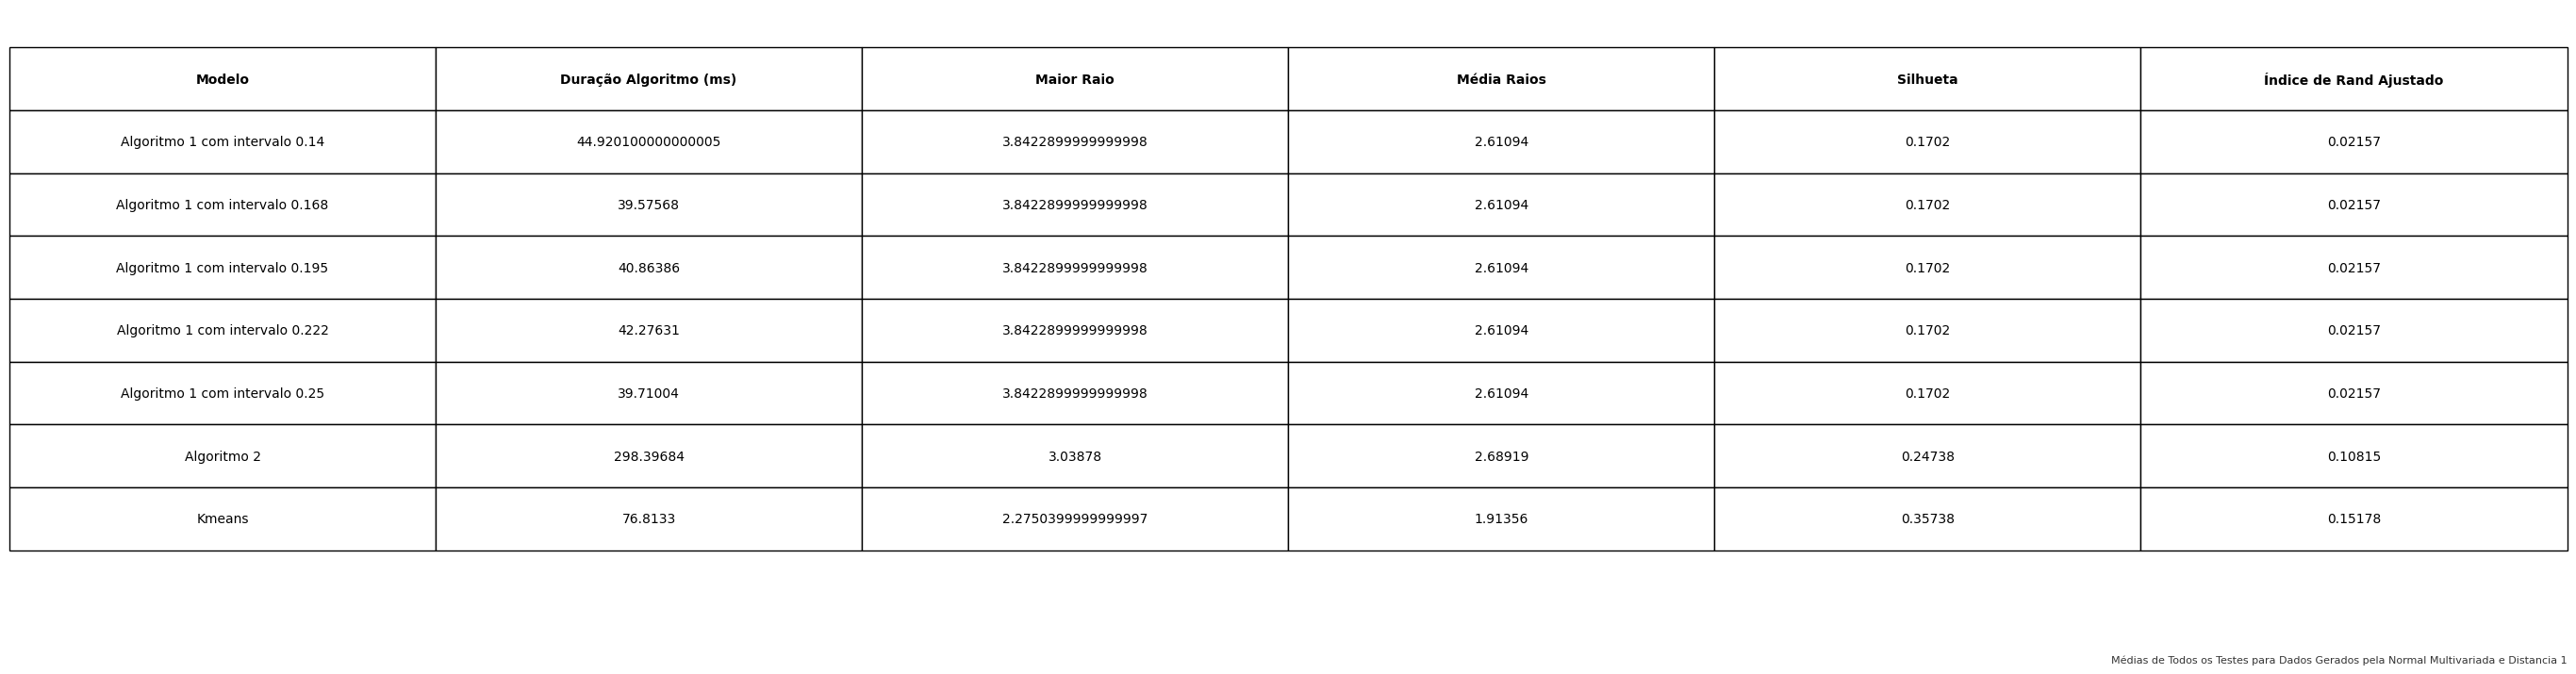

Latex da tabela:
\begin{tabular}{lrrrrr}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 44.920100 & 3.842290 & 2.610940 & 0.170200 & 0.021570 \\
Algoritmo 1 com intervalo 0.168 & 39.575680 & 3.842290 & 2.610940 & 0.170200 & 0.021570 \\
Algoritmo 1 com intervalo 0.195 & 40.863860 & 3.842290 & 2.610940 & 0.170200 & 0.021570 \\
Algoritmo 1 com intervalo 0.222 & 42.276310 & 3.842290 & 2.610940 & 0.170200 & 0.021570 \\
Algoritmo 1 com intervalo 0.25 & 39.710040 & 3.842290 & 2.610940 & 0.170200 & 0.021570 \\
Algoritmo 2 & 298.396840 & 3.038780 & 2.689190 & 0.247380 & 0.108150 \\
Kmeans & 76.813300 & 2.275040 & 1.913560 & 0.357380 & 0.151780 \\
\bottomrule
\end{tabular}



In [ ]:
n_experimentos = 30

combined_results = []
dataset_titles = []
for i in range(0,10):
    labels = labels_list_normal[i]  
    nome_test = f"Resultados para a dataset gerado  seguindo uma normal multivariada com desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters"
    dataset_titles.append("Dataset seguindo uma normal multivariada com desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters")
    data = np.column_stack((data_normal[i][:, 0], data_normal[i][:, 1]))

    df_resultado = executeAll(np.array(data), n_clusters_normal[i], 1, labels, nome_test, n_experimentos)
    
    print(nome_test)
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles)
mean_results = combined_df.groupby("Modelo").mean().reset_index()

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias de Todos os Testes para Dados Gerados pela Normal Multivariada e Distancia 1", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=mean_results.values, colLabels=mean_results.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = mean_results.to_latex(index=False, 
                         caption='Resultados para dataset seguindo uma normal multivariada', 
                         label='tab:nm11', 
                         column_format='|c|c|c|', 
                         float_format="%.2f")

latex_code = mean_results.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Normal multivariada com Distancia 2

Resultados para a dataset gerado com o desvio padrão 0.1 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,5.1291,3.5291,2.3054,0.1963,0.0002
1,Algoritmo 1 com intervalo 0.168,5.1690,3.5291,2.3054,0.1963,0.0002
2,Algoritmo 1 com intervalo 0.195,4.4660,3.5291,2.3054,0.1963,0.0002
3,Algoritmo 1 com intervalo 0.222,4.4253,3.5291,2.3054,0.1963,0.0002
4,Algoritmo 1 com intervalo 0.25,4.3460,3.5291,2.3054,0.1963,0.0002
5,Algoritmo 2,6.1309,2.8491,2.7014,0.5611,0.7911
6,Kmeans,5.5540,1.9264,1.7792,0.5989,0.9406


Resultados para a dataset gerado com o desvio padrão 0.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,7.7617,3.5682,3.4176,0.4229,0.0000
1,Algoritmo 1 com intervalo 0.168,8.0122,3.5682,3.4176,0.4229,0.0000
2,Algoritmo 1 com intervalo 0.195,8.8101,3.5682,3.4176,0.4229,0.0000
3,Algoritmo 1 com intervalo 0.222,8.0046,3.5682,3.4176,0.4229,0.0000
4,Algoritmo 1 com intervalo 0.25,18.3093,3.5682,3.4176,0.4229,0.0000
5,Algoritmo 2,19.0247,2.8181,2.5399,0.2353,0.0105
6,Kmeans,6.0650,2.8240,2.5295,0.3293,0.0468


Resultados para a dataset gerado com o desvio padrão 0.3 e 8 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,85.2315,2.4075,1.2589,0.0495,0.0072
1,Algoritmo 1 com intervalo 0.168,70.4244,2.4075,1.2589,0.0495,0.0072
2,Algoritmo 1 com intervalo 0.195,69.7873,2.4075,1.2589,0.0495,0.0072
3,Algoritmo 1 com intervalo 0.222,73.9137,2.4075,1.2589,0.0495,0.0072
4,Algoritmo 1 com intervalo 0.25,84.7675,2.4075,1.2589,0.0495,0.0072
5,Algoritmo 2,608.6963,1.7856,1.4742,0.1810,0.0916
6,Kmeans,151.3890,1.9185,1.4260,0.3218,0.1352


Resultados para a dataset gerado com o desvio padrão 1.0 e 4 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,12.4390,3.3509,1.8804,0.4188,0.0001
1,Algoritmo 1 com intervalo 0.168,11.9453,3.3509,1.8804,0.4188,0.0001
2,Algoritmo 1 com intervalo 0.195,20.7981,3.3509,1.8804,0.4188,0.0001
3,Algoritmo 1 com intervalo 0.222,14.5322,3.3509,1.8804,0.4188,0.0001
4,Algoritmo 1 com intervalo 0.25,13.3641,3.3509,1.8804,0.4188,0.0001
5,Algoritmo 2,44.1439,2.5654,2.1573,0.2270,0.0025
6,Kmeans,12.1130,2.3254,2.1033,0.3121,0.0158


Resultados para a dataset gerado com o desvio padrão 0.2 e 10 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,101.5645,1.6317,1.2017,0.0829,0.0685
1,Algoritmo 1 com intervalo 0.168,100.2027,1.6317,1.2017,0.0829,0.0685
2,Algoritmo 1 com intervalo 0.195,99.2436,1.6317,1.2017,0.0829,0.0685
3,Algoritmo 1 com intervalo 0.222,108.8386,1.6317,1.2017,0.0829,0.0685
4,Algoritmo 1 com intervalo 0.25,108.9308,1.6317,1.2017,0.0829,0.0685
5,Algoritmo 2,1217.8888,1.4612,1.1715,0.2207,0.1409
6,Kmeans,150.0220,1.8655,1.2706,0.3399,0.1980


Resultados para a dataset gerado com o desvio padrão 0.7 e 5 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,36.2953,2.4666,2.0772,0.1270,0.0001
1,Algoritmo 1 com intervalo 0.168,42.3310,2.4666,2.0772,0.1270,0.0001
2,Algoritmo 1 com intervalo 0.195,31.9046,2.4666,2.0772,0.1270,0.0001
3,Algoritmo 1 com intervalo 0.222,37.9000,2.4666,2.0772,0.1270,0.0001
4,Algoritmo 1 com intervalo 0.25,36.6216,2.4666,2.0772,0.1270,0.0001
5,Algoritmo 2,147.2269,2.2138,2.0816,0.1241,0.0056
6,Kmeans,153.6840,1.9198,1.6969,0.3443,0.0484


Resultados para a dataset gerado com o desvio padrão 0.4 e 7 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,69.3326,2.6306,1.7786,0.1904,0.0274
1,Algoritmo 1 com intervalo 0.168,56.9948,2.6306,1.7786,0.1904,0.0274
2,Algoritmo 1 com intervalo 0.195,59.6443,2.6306,1.7786,0.1904,0.0274
3,Algoritmo 1 com intervalo 0.222,64.3717,2.6306,1.7786,0.1904,0.0274
4,Algoritmo 1 com intervalo 0.25,75.7751,2.6306,1.7786,0.1904,0.0274
5,Algoritmo 2,386.3497,1.9491,1.6024,0.2551,0.0582
6,Kmeans,36.4060,2.2734,1.7214,0.3283,0.0755


Resultados para a dataset gerado com o desvio padrão 1.5 e 3 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,4.4563,3.9018,3.9018,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,4.5541,3.9018,3.9018,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,4.3190,3.9018,3.9018,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,4.3168,3.9018,3.9018,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,4.3142,3.9018,3.9018,0.0000,0.0000
5,Algoritmo 2,11.9896,2.9134,2.4882,0.2292,0.0014
6,Kmeans,6.1580,2.4199,2.0943,0.3623,0.0034


Resultados para a dataset gerado com o desvio padrão 0.6 e 2 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,6.3491,3.6470,3.6470,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,6.7537,3.6470,3.6470,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,4.0107,3.6470,3.6470,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,3.0007,3.6470,3.6470,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,3.2705,3.6470,3.6470,0.0000,0.0000
5,Algoritmo 2,5.1488,3.1879,3.0711,0.3028,0.0146
6,Kmeans,4.2090,2.9110,2.7506,0.2932,0.0207


Resultados para a dataset gerado com o desvio padrão 0.9 e 6 clusters


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,49.1737,2.5232,2.0624,0.2204,0.0166
1,Algoritmo 1 com intervalo 0.168,56.6269,2.5232,2.0624,0.2204,0.0166
2,Algoritmo 1 com intervalo 0.195,50.8686,2.5232,2.0624,0.2204,0.0166
3,Algoritmo 1 com intervalo 0.222,68.0729,2.5232,2.0624,0.2204,0.0166
4,Algoritmo 1 com intervalo 0.25,55.9544,2.5232,2.0624,0.2204,0.0166
5,Algoritmo 2,259.6593,2.2249,1.7501,0.2267,0.0258
6,Kmeans,151.3060,2.3665,1.7638,0.3437,0.0334


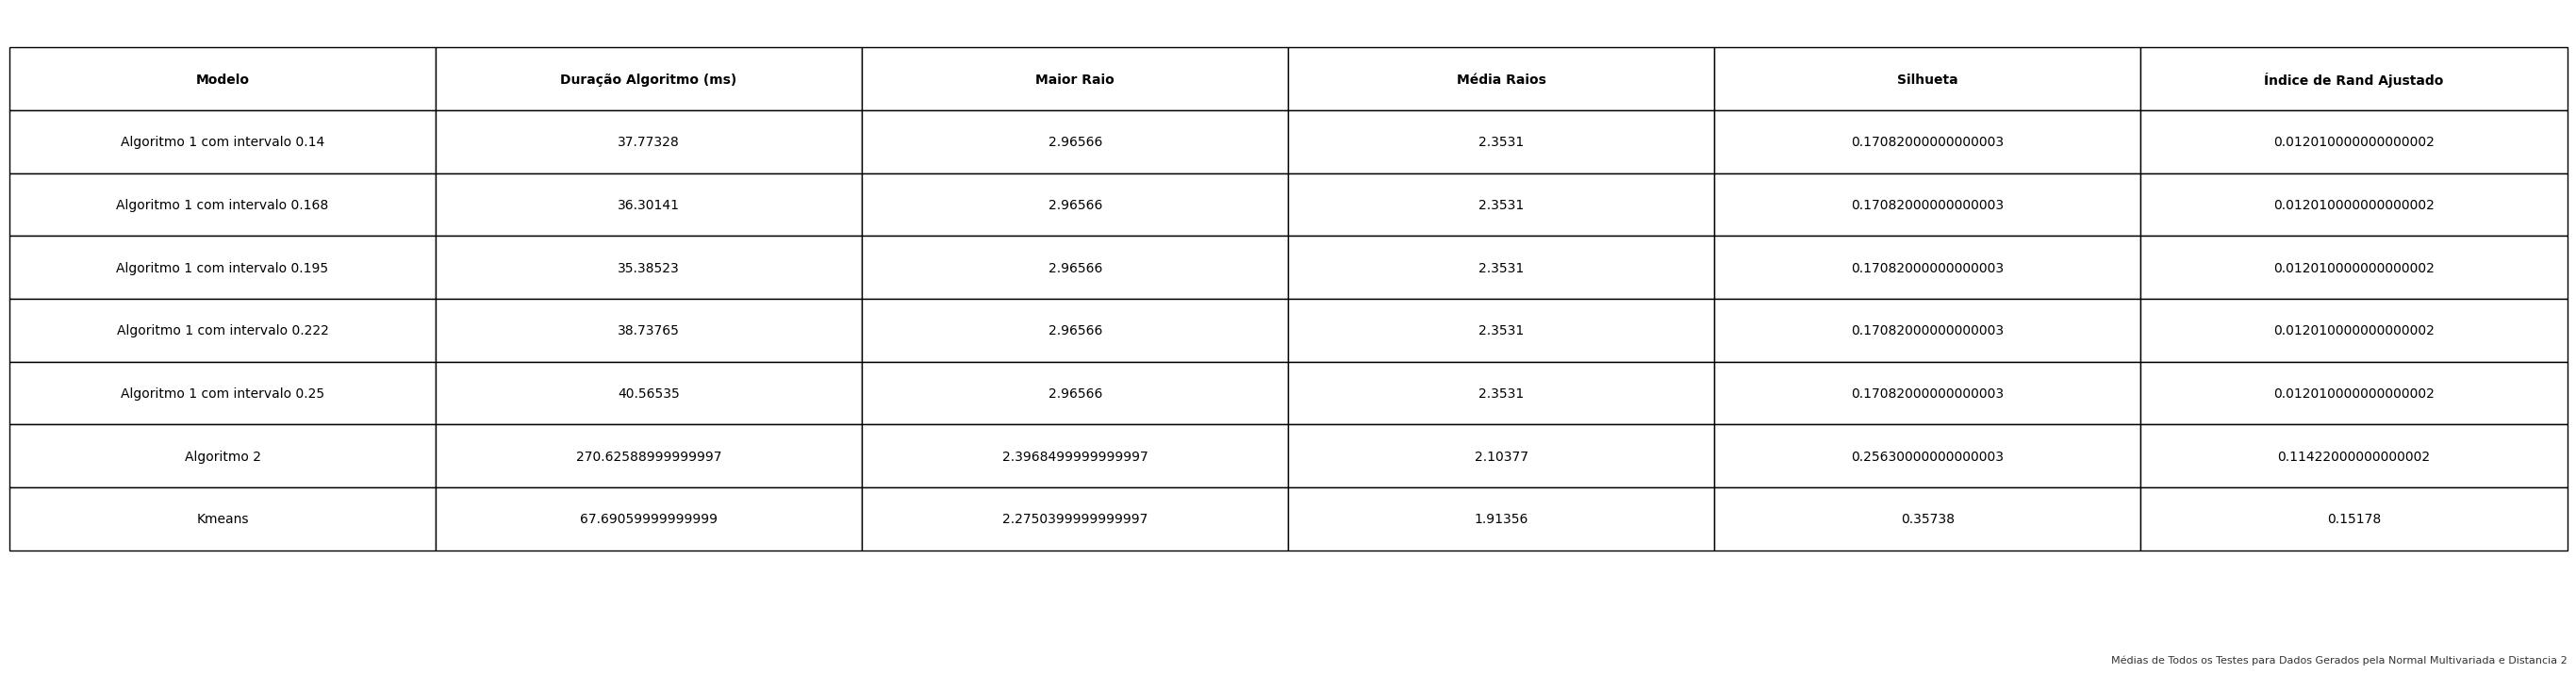

Latex da tabela:
\begin{tabular}{lrrrrr}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 37.773280 & 2.965660 & 2.353100 & 0.170820 & 0.012010 \\
Algoritmo 1 com intervalo 0.168 & 36.301410 & 2.965660 & 2.353100 & 0.170820 & 0.012010 \\
Algoritmo 1 com intervalo 0.195 & 35.385230 & 2.965660 & 2.353100 & 0.170820 & 0.012010 \\
Algoritmo 1 com intervalo 0.222 & 38.737650 & 2.965660 & 2.353100 & 0.170820 & 0.012010 \\
Algoritmo 1 com intervalo 0.25 & 40.565350 & 2.965660 & 2.353100 & 0.170820 & 0.012010 \\
Algoritmo 2 & 270.625890 & 2.396850 & 2.103770 & 0.256300 & 0.114220 \\
Kmeans & 67.690600 & 2.275040 & 1.913560 & 0.357380 & 0.151780 \\
\bottomrule
\end{tabular}



In [ ]:
n_experimentos = 30

combined_results = []
dataset_titles = []

for i in range(0,10):
    labels = labels_list_normal[i]  
    nome_test = f"Resultados para a dataset gerado com o desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters"
    data = np.column_stack((data_normal[i][:, 0], data_normal[i][:, 1]))
    dataset_titles.append("Dataset seguindo uma normal multivariada com desvio padrão {std_devs[i]} e {n_clusters_normal[i]} clusters")

    df_resultado = executeAll(np.array(data), n_clusters_normal[i], 2, labels, nome_test, n_experimentos)
    
    print(nome_test)
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles)
mean_results = combined_df.groupby("Modelo").mean().reset_index()

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias de Todos os Testes para Dados Gerados pela Normal Multivariada e Distancia 2", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=mean_results.values, colLabels=mean_results.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = mean_results.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Exemplos do scikit learn com Distancia 1

Resultados para Noisy Circles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,50.2277,2.3269,1.7531,0.2337,0.0627
1,Algoritmo 1 com intervalo 0.168,45.7164,2.3269,1.7531,0.2337,0.0627
2,Algoritmo 1 com intervalo 0.195,42.7369,2.3269,1.7531,0.2337,0.0627
3,Algoritmo 1 com intervalo 0.222,39.3409,2.3269,1.7531,0.2337,0.0627
4,Algoritmo 1 com intervalo 0.25,36.1961,2.3269,1.7531,0.2337,0.0627
5,Algoritmo 2,39.8461,1.9307,1.9213,0.3454,0.0016
6,Kmeans,39.3770,1.1543,1.1486,0.3516,-0.0019


Resultados para Noisy Moons


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,10.4058,2.5049,2.5049,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,10.0658,2.5049,2.5049,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,10.3276,2.5049,2.5049,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,10.4289,2.5049,2.5049,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,10.3528,2.5049,2.5049,0.0000,0.0000
5,Algoritmo 2,41.2248,1.6284,1.6215,0.4491,0.3124
6,Kmeans,40.0140,1.0099,1.0036,0.4879,0.2327


Resultados para Blobs


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,38.1903,10.3231,5.1616,0.2534,0.0000
1,Algoritmo 1 com intervalo 0.168,46.1624,10.3231,5.1616,0.2534,0.0000
2,Algoritmo 1 com intervalo 0.195,34.9278,10.3231,5.1616,0.2534,0.0000
3,Algoritmo 1 com intervalo 0.222,41.1943,10.3231,5.1616,0.2534,0.0000
4,Algoritmo 1 com intervalo 0.25,49.9184,10.3231,5.1616,0.2534,0.0000
5,Algoritmo 2,102.7651,7.3351,6.0418,0.3211,0.3780
6,Kmeans,64.1180,4.2143,3.4453,0.6471,0.9703


Resultados para Aniso


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,43.3861,5.9485,5.0297,0.6128,0.5000
1,Algoritmo 1 com intervalo 0.168,53.2498,5.9485,5.0297,0.6128,0.5000
2,Algoritmo 1 com intervalo 0.195,45.0994,5.9485,5.0297,0.6128,0.5000
3,Algoritmo 1 com intervalo 0.222,41.3609,5.9485,5.0297,0.6128,0.5000
4,Algoritmo 1 com intervalo 0.25,49.3331,5.9485,5.0297,0.6128,0.5000
5,Algoritmo 2,99.9521,3.4323,3.4201,0.4038,0.3616
6,Kmeans,48.6230,2.8363,2.6849,0.5007,0.5554


Resultados para Varied


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,50.7029,12.9585,8.6311,0.4761,0.5251
1,Algoritmo 1 com intervalo 0.168,47.3929,12.9585,8.6311,0.4761,0.5251
2,Algoritmo 1 com intervalo 0.195,38.7137,12.9585,8.6311,0.4761,0.5251
3,Algoritmo 1 com intervalo 0.222,44.8764,12.9585,8.6311,0.4761,0.5251
4,Algoritmo 1 com intervalo 0.25,48.2038,12.9585,8.6311,0.4761,0.5251
5,Algoritmo 2,104.4062,10.2227,9.6425,0.5794,0.6076
6,Kmeans,136.0370,6.9001,6.5023,0.6549,0.7872


Resultados para Iris


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,7.2664,1.8000,1.2000,0.0101,0.1524
1,Algoritmo 1 com intervalo 0.168,6.9108,1.8000,1.2000,0.0101,0.1524
2,Algoritmo 1 com intervalo 0.195,7.0419,1.8000,1.2000,0.0101,0.1524
3,Algoritmo 1 com intervalo 0.222,7.1207,1.8000,1.2000,0.0101,0.1524
4,Algoritmo 1 com intervalo 0.25,6.8169,1.8000,1.2000,0.0101,0.1524
5,Algoritmo 2,20.8151,1.7000,1.6000,0.3690,0.4132
6,Kmeans,37.8200,1.6468,1.4821,0.5512,0.7163


Resultados para Wine


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,12.1973,2.6500,2.3667,-0.1570,0.0766
1,Algoritmo 1 com intervalo 0.168,6.8318,2.6500,2.3667,-0.1570,0.0766
2,Algoritmo 1 com intervalo 0.195,5.1084,2.6500,2.3667,-0.1570,0.0766
3,Algoritmo 1 com intervalo 0.222,4.8286,2.6500,2.3667,-0.1570,0.0766
4,Algoritmo 1 com intervalo 0.25,4.6682,2.6500,2.3667,-0.1570,0.0766
5,Algoritmo 2,16.9615,2.9200,2.7167,-0.0228,0.3371
6,Kmeans,13.4990,484.8684,293.9848,0.5711,0.3711


Resultados para Breast Cancer


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,57.7051,26.0670,18.8885,0.0167,0.0009
1,Algoritmo 1 com intervalo 0.168,42.0412,26.0670,18.8885,0.0167,0.0009
2,Algoritmo 1 com intervalo 0.195,43.0064,26.0670,18.8885,0.0167,0.0009
3,Algoritmo 1 com intervalo 0.222,43.9617,26.0670,18.8885,0.0167,0.0009
4,Algoritmo 1 com intervalo 0.25,54.4322,26.0670,18.8885,0.0167,0.0009
5,Algoritmo 2,73.8254,23.7400,22.7500,-0.0272,0.0017
6,Kmeans,155.7280,2862.8902,1754.9912,0.6973,0.4914


Resultados para Classification


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,11.5930,6.9223,6.9223,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,11.5658,6.9223,6.9223,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,22.6339,6.9223,6.9223,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,14.3168,6.9223,6.9223,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,12.0434,6.9223,6.9223,0.0000,0.0000
5,Algoritmo 2,43.8008,6.6107,6.1467,0.1949,0.0021
6,Kmeans,135.9890,3.8161,3.6474,0.5218,0.3589


Resultados para Gaussian Quantiles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,10.6684,6.2880,6.2880,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,10.1159,6.2880,6.2880,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,10.5121,6.2880,6.2880,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,24.8488,6.2880,6.2880,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,12.8313,6.2880,6.2880,0.0000,0.0000
5,Algoritmo 2,50.9655,4.9814,4.4289,0.2940,0.0840
6,Kmeans,49.2310,3.3137,3.2490,0.3207,-0.0012


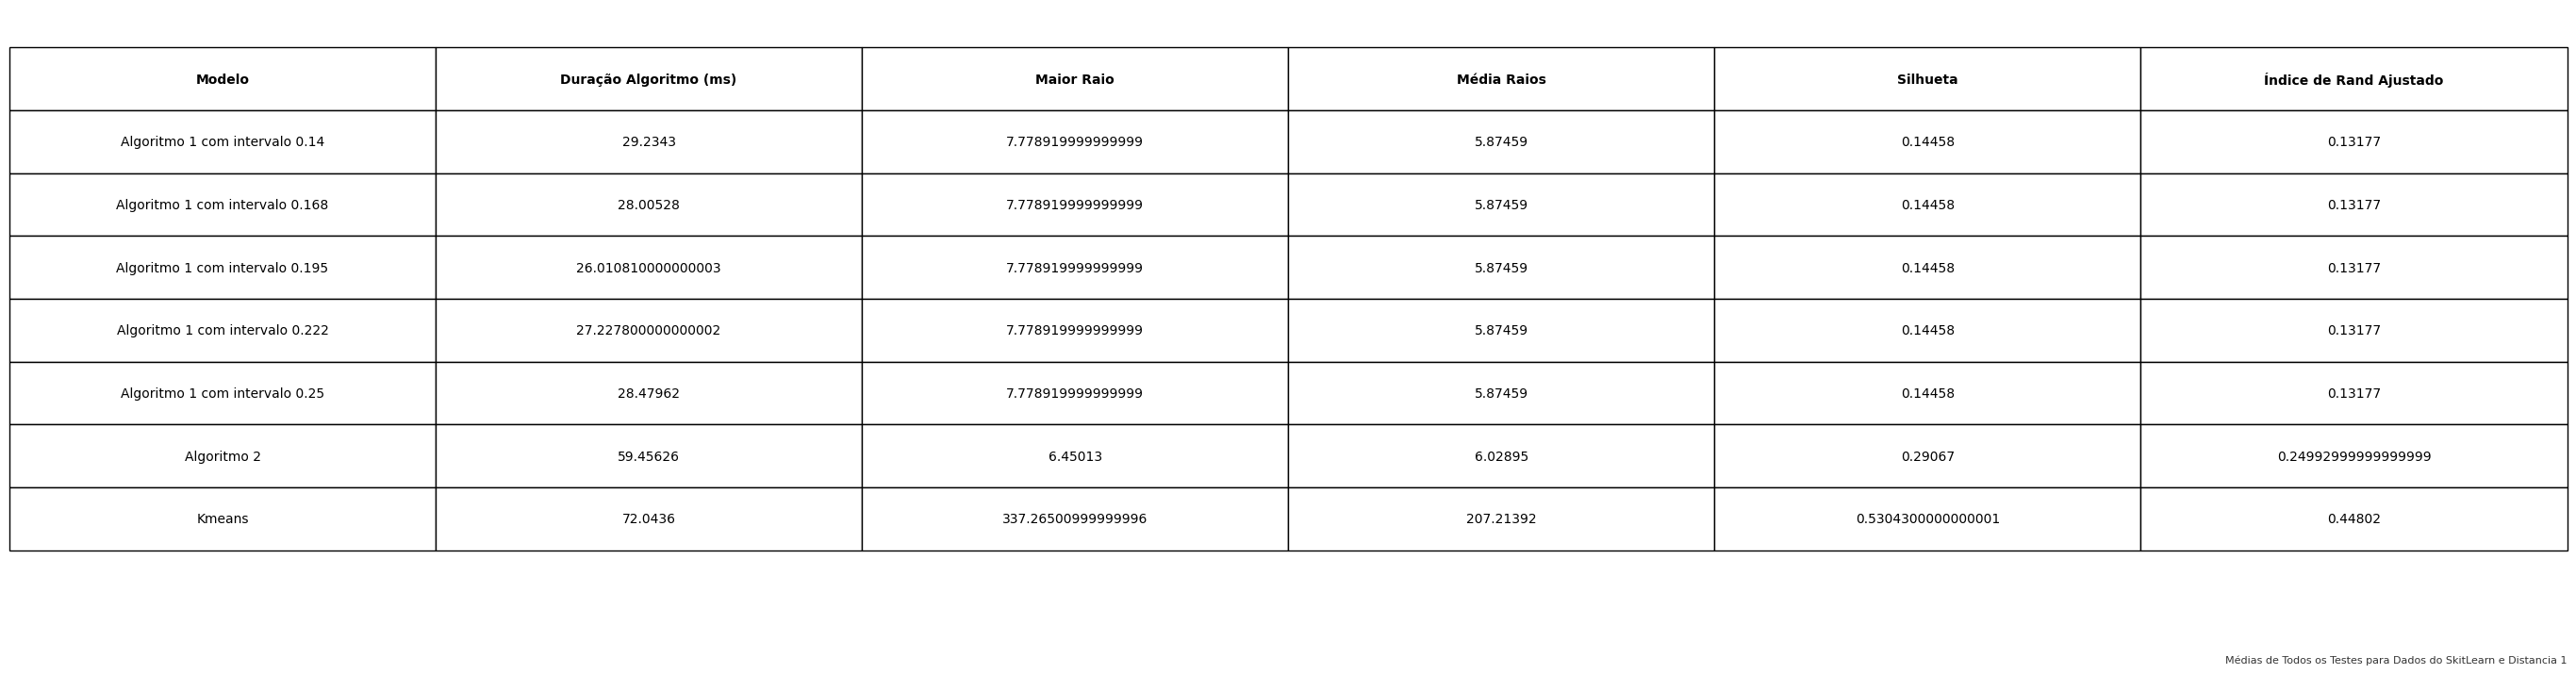

Latex da tabela:
\begin{tabular}{lrrrrr}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 29.234300 & 7.778920 & 5.874590 & 0.144580 & 0.131770 \\
Algoritmo 1 com intervalo 0.168 & 28.005280 & 7.778920 & 5.874590 & 0.144580 & 0.131770 \\
Algoritmo 1 com intervalo 0.195 & 26.010810 & 7.778920 & 5.874590 & 0.144580 & 0.131770 \\
Algoritmo 1 com intervalo 0.222 & 27.227800 & 7.778920 & 5.874590 & 0.144580 & 0.131770 \\
Algoritmo 1 com intervalo 0.25 & 28.479620 & 7.778920 & 5.874590 & 0.144580 & 0.131770 \\
Algoritmo 2 & 59.456260 & 6.450130 & 6.028950 & 0.290670 & 0.249930 \\
Kmeans & 72.043600 & 337.265010 & 207.213920 & 0.530430 & 0.448020 \\
\bottomrule
\end{tabular}



In [ ]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster in zip(datasets_list_sklearn, dataset_titles_sklearn,k_clusters_sklearn):
    labels = data[1]  
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 1, labels, nome_test, n_experimentos)
    
    print(f"Resultados para {title}")
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles_sklearn)
mean_results = combined_df.groupby("Modelo").mean().reset_index()

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias de Todos os Testes para Dados do SkitLearn e Distancia 1", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=mean_results.values, colLabels=mean_results.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = mean_results.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Exemplos do scikit learn com Distancia 2

Resultados para Noisy Circles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,158.2010,1.8550,1.5776,0.2428,0.0731
1,Algoritmo 1 com intervalo 0.168,41.2641,1.9029,1.5885,0.2271,0.0530
2,Algoritmo 1 com intervalo 0.195,15.7280,2.1084,2.1084,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,13.0044,2.1084,2.1084,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,14.0337,2.1084,2.1084,0.0000,0.0000
5,Algoritmo 2,59.0522,1.5618,1.5468,0.3510,-0.0018
6,Kmeans,145.3840,1.1543,1.1486,0.3516,-0.0019


Resultados para Noisy Moons


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,55.5324,1.7530,1.3727,0.3522,0.0820
1,Algoritmo 1 com intervalo 0.168,45.3358,1.7530,1.3727,0.3522,0.0820
2,Algoritmo 1 com intervalo 0.195,47.7276,1.7530,1.3727,0.3522,0.0820
3,Algoritmo 1 com intervalo 0.222,41.7110,1.7530,1.3727,0.3522,0.0820
4,Algoritmo 1 com intervalo 0.25,43.9756,1.7530,1.3727,0.3522,0.0820
5,Algoritmo 2,44.2351,1.2239,1.2092,0.4413,0.2609
6,Kmeans,145.1810,1.0099,1.0036,0.4879,0.2327


Resultados para Blobs


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,39.2138,7.3925,4.7488,0.2330,0.0004
1,Algoritmo 1 com intervalo 0.168,45.0779,7.3925,4.7488,0.2330,0.0004
2,Algoritmo 1 com intervalo 0.195,49.0197,7.3925,4.7488,0.2330,0.0004
3,Algoritmo 1 com intervalo 0.222,48.1527,7.3925,4.7488,0.2330,0.0004
4,Algoritmo 1 com intervalo 0.25,43.2040,7.3925,4.7488,0.2330,0.0004
5,Algoritmo 2,97.7639,5.3412,4.3739,0.3565,0.4188
6,Kmeans,63.5730,4.2143,3.4453,0.6471,0.9703


Resultados para Aniso


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,42.8102,4.2437,3.9674,0.6231,0.5176
1,Algoritmo 1 com intervalo 0.168,43.9214,4.2437,3.9674,0.6231,0.5176
2,Algoritmo 1 com intervalo 0.195,37.9038,4.2437,3.9674,0.6231,0.5176
3,Algoritmo 1 com intervalo 0.222,38.7169,4.2437,3.9674,0.6231,0.5176
4,Algoritmo 1 com intervalo 0.25,40.5940,4.2437,3.9674,0.6231,0.5176
5,Algoritmo 2,89.0008,3.0512,2.9975,0.4508,0.4519
6,Kmeans,31.3100,2.8363,2.6849,0.5007,0.5554


Resultados para Varied


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,40.6157,9.3795,6.8884,0.5232,0.5087
1,Algoritmo 1 com intervalo 0.168,49.4768,9.3795,6.8884,0.5232,0.5087
2,Algoritmo 1 com intervalo 0.195,47.4813,9.3795,6.8884,0.5232,0.5087
3,Algoritmo 1 com intervalo 0.222,42.4958,9.3795,6.8884,0.5232,0.5087
4,Algoritmo 1 com intervalo 0.25,41.3540,9.3795,6.8884,0.5232,0.5087
5,Algoritmo 2,91.8853,8.1797,7.6437,0.6013,0.6129
6,Kmeans,133.9960,6.9001,6.5023,0.6549,0.7872


Resultados para Iris


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,9.3901,1.3892,1.2299,0.0657,0.1647
1,Algoritmo 1 com intervalo 0.168,7.9116,1.3892,1.2299,0.0657,0.1647
2,Algoritmo 1 com intervalo 0.195,4.8468,1.3892,1.2299,0.0657,0.1647
3,Algoritmo 1 com intervalo 0.222,4.8864,1.3892,1.2299,0.0657,0.1647
4,Algoritmo 1 com intervalo 0.25,4.6004,1.3892,1.2299,0.0657,0.1647
5,Algoritmo 2,7.5508,1.5033,1.2466,0.3707,0.3834
6,Kmeans,5.9260,1.6468,1.4821,0.5512,0.7163


Resultados para Wine


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,13.5339,3.9742,2.2848,-0.1781,0.0004
1,Algoritmo 1 com intervalo 0.168,6.8934,3.9742,2.2848,-0.1781,0.0004
2,Algoritmo 1 com intervalo 0.195,4.9308,3.9742,2.2848,-0.1781,0.0004
3,Algoritmo 1 com intervalo 0.222,4.1711,3.9742,2.2848,-0.1781,0.0004
4,Algoritmo 1 com intervalo 0.25,4.9115,3.9742,2.2848,-0.1781,0.0004
5,Algoritmo 2,7.7936,2.2771,2.2681,-0.0250,0.3483
6,Kmeans,4.4480,484.8684,293.9848,0.5711,0.3711


Resultados para Breast Cancer


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,64.0291,16.9935,14.9680,0.2599,0.0107
1,Algoritmo 1 com intervalo 0.168,52.7681,16.9935,14.9680,0.2599,0.0107
2,Algoritmo 1 com intervalo 0.195,53.2950,16.9935,14.9680,0.2599,0.0107
3,Algoritmo 1 com intervalo 0.222,52.3480,16.9935,14.9680,0.2599,0.0107
4,Algoritmo 1 com intervalo 0.25,53.2403,16.9935,14.9680,0.2599,0.0107
5,Algoritmo 2,67.0589,17.4688,17.2046,0.2288,0.0407
6,Kmeans,161.8050,2862.8902,1754.9912,0.6973,0.4914


Resultados para Classification


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,11.7151,4.9541,4.9541,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,11.3389,4.9541,4.9541,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,18.7439,4.9541,4.9541,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,13.2072,4.9541,4.9541,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,11.4140,4.9541,4.9541,0.0000,0.0000
5,Algoritmo 2,40.7430,4.7353,3.6072,0.1570,0.0025
6,Kmeans,128.0420,3.8161,3.6474,0.5218,0.3589


Resultados para Gaussian Quantiles


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,11.0394,4.5092,4.5092,0.0000,0.0000
1,Algoritmo 1 com intervalo 0.168,10.0994,4.5092,4.5092,0.0000,0.0000
2,Algoritmo 1 com intervalo 0.195,10.0998,4.5092,4.5092,0.0000,0.0000
3,Algoritmo 1 com intervalo 0.222,9.8120,4.5092,4.5092,0.0000,0.0000
4,Algoritmo 1 com intervalo 0.25,9.9602,4.5092,4.5092,0.0000,0.0000
5,Algoritmo 2,46.6477,3.6284,3.4351,0.2980,0.0864
6,Kmeans,154.0180,3.3137,3.2490,0.3207,-0.0012


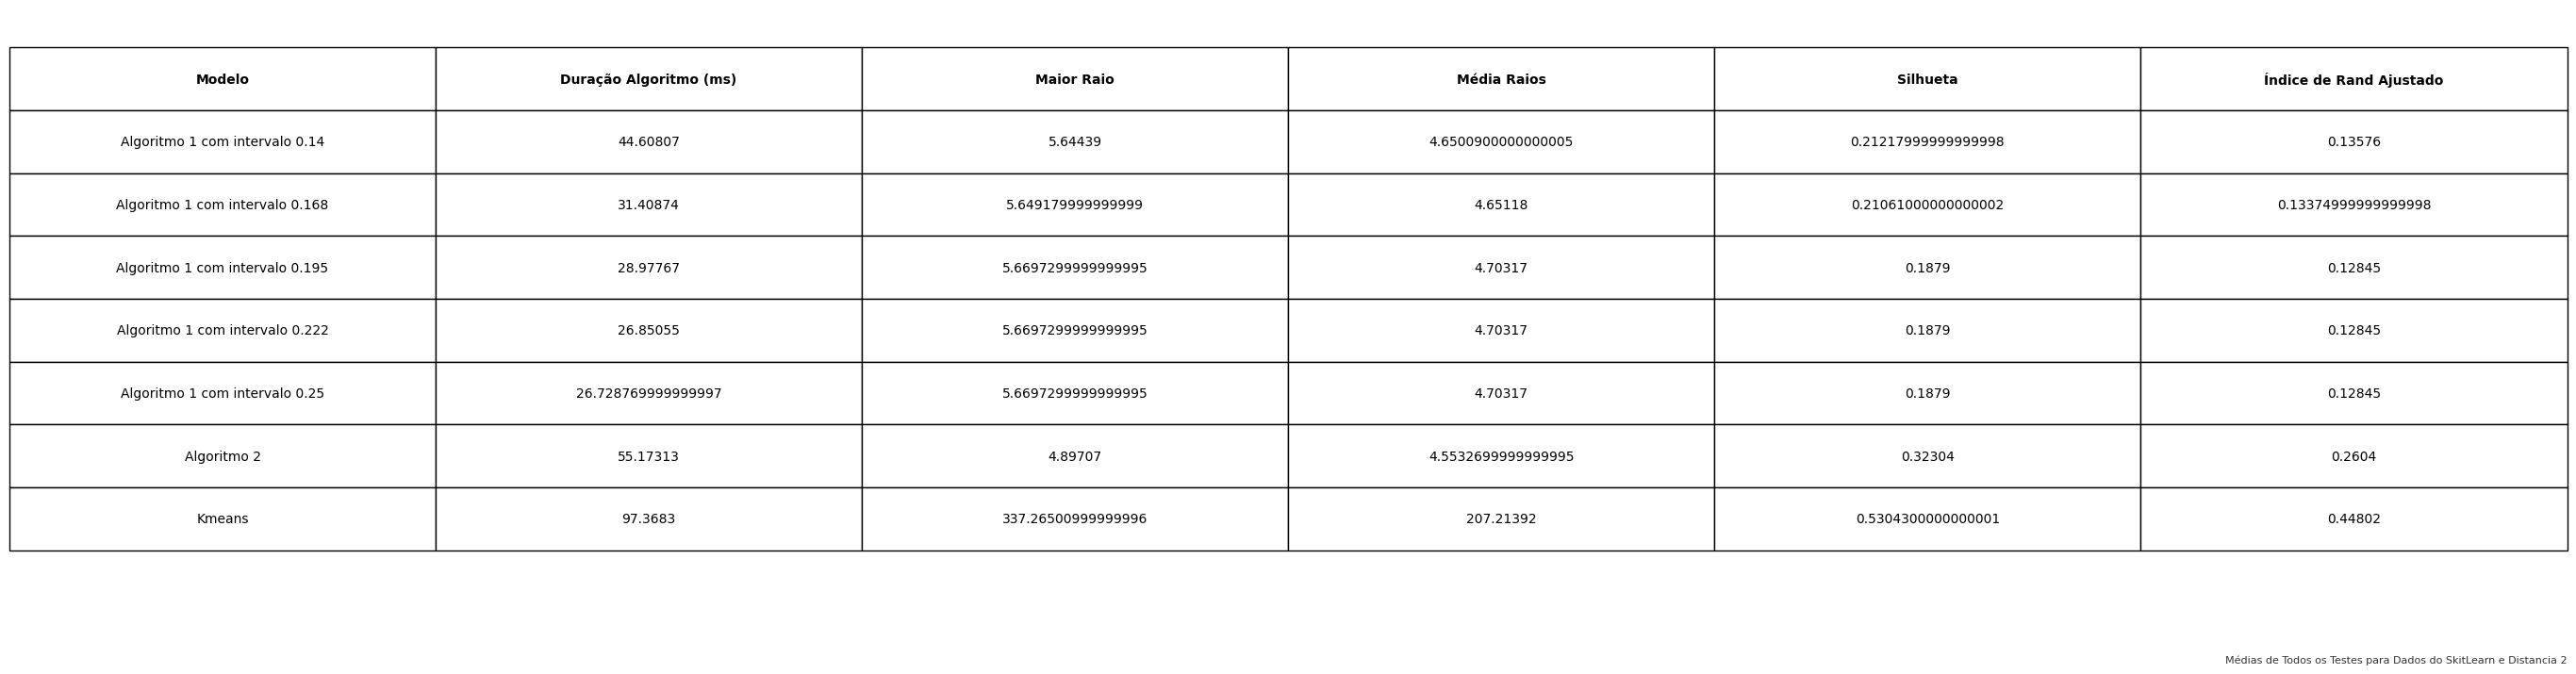

Latex da tabela:
\begin{tabular}{lrrrrr}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 44.608070 & 5.644390 & 4.650090 & 0.212180 & 0.135760 \\
Algoritmo 1 com intervalo 0.168 & 31.408740 & 5.649180 & 4.651180 & 0.210610 & 0.133750 \\
Algoritmo 1 com intervalo 0.195 & 28.977670 & 5.669730 & 4.703170 & 0.187900 & 0.128450 \\
Algoritmo 1 com intervalo 0.222 & 26.850550 & 5.669730 & 4.703170 & 0.187900 & 0.128450 \\
Algoritmo 1 com intervalo 0.25 & 26.728770 & 5.669730 & 4.703170 & 0.187900 & 0.128450 \\
Algoritmo 2 & 55.173130 & 4.897070 & 4.553270 & 0.323040 & 0.260400 \\
Kmeans & 97.368300 & 337.265010 & 207.213920 & 0.530430 & 0.448020 \\
\bottomrule
\end{tabular}



In [ ]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster in zip(datasets_list_sklearn, dataset_titles_sklearn,k_clusters_sklearn):
    labels = data[1]  
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 2, labels, nome_test, n_experimentos)

    print(f"Resultados para {title}")
    display(df_resultado)

    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=dataset_titles_sklearn)
mean_results = combined_df.groupby("Modelo").mean().reset_index()

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias de Todos os Testes para Dados do SkitLearn e Distancia 2", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=mean_results.values, colLabels=mean_results.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = mean_results.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Dados Reais com Distancia 1

Resultados para hepatitis


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,57.3090,301557.0000,258810.7500,0.5319,0.0007
1,Algoritmo 1 com intervalo 0.168,64.0304,301557.0000,258810.7500,0.5319,0.0007
2,Algoritmo 1 com intervalo 0.195,57.7576,301557.0000,258810.7500,0.5319,0.0007
3,Algoritmo 1 com intervalo 0.222,67.6143,301557.0000,258810.7500,0.5319,0.0007
4,Algoritmo 1 com intervalo 0.25,60.5248,301557.0000,258810.7500,0.5319,0.0007
5,Algoritmo 2,185.4429,297882.0000,224383.2500,0.5267,-0.0004
6,Kmeans,145.0510,160733.4373,150089.6358,0.5774,-0.0013


Resultados para raisin


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,68.1174,77967.0527,71968.0322,0.6431,0.0252
1,Algoritmo 1 com intervalo 0.168,56.5522,77967.0527,71968.0322,0.6431,0.0252
2,Algoritmo 1 com intervalo 0.195,56.7492,77967.0527,71968.0322,0.6431,0.0252
3,Algoritmo 1 com intervalo 0.222,54.9799,77967.0527,71968.0322,0.6431,0.0252
4,Algoritmo 1 com intervalo 0.25,55.3561,77967.0527,71968.0322,0.6431,0.0252
5,Algoritmo 2,86.5157,79171.0796,78170.5497,0.6425,0.0243
6,Kmeans,147.1790,86183.2102,65224.8731,0.6439,0.1756


Resultados para mice_protein


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,57.5688,1.1586,0.6981,0.6217,0.0017
1,Algoritmo 1 com intervalo 0.168,61.2393,1.1586,0.6981,0.6217,0.0017
2,Algoritmo 1 com intervalo 0.195,57.4236,1.1586,0.6981,0.6217,0.0017
3,Algoritmo 1 com intervalo 0.222,58.5844,1.1586,0.6981,0.6217,0.0017
4,Algoritmo 1 com intervalo 0.25,69.7903,1.1586,0.6981,0.6217,0.0017
5,Algoritmo 2,514.4948,0.3894,0.2623,0.5315,0.0785
6,Kmeans,103.6500,0.3890,0.2252,0.4470,0.1091


Resultados para yeast


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,54.4593,0.3000,0.1850,0.1185,-0.0222
1,Algoritmo 1 com intervalo 0.168,53.1422,0.3000,0.1850,0.1185,-0.0222
2,Algoritmo 1 com intervalo 0.195,63.4609,0.3000,0.1850,0.1185,-0.0222
3,Algoritmo 1 com intervalo 0.222,53.1732,0.3000,0.1850,0.1185,-0.0222
4,Algoritmo 1 com intervalo 0.25,58.4806,0.3000,0.1850,0.1185,-0.0222
5,Algoritmo 2,511.3352,0.2400,0.1810,0.3200,0.0468
6,Kmeans,103.3790,0.2697,0.1725,0.3679,0.0620


Resultados para maternal_risk


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,40.2338,20.0000,6.6667,0.3533,0.0004
1,Algoritmo 1 com intervalo 0.168,42.7885,20.0000,6.6667,0.3533,0.0004
2,Algoritmo 1 com intervalo 0.195,39.4034,20.0000,6.6667,0.3533,0.0004
3,Algoritmo 1 com intervalo 0.222,46.0512,20.0000,6.6667,0.3533,0.0004
4,Algoritmo 1 com intervalo 0.25,49.5821,20.0000,6.6667,0.3533,0.0004
5,Algoritmo 2,68.3893,12.0000,7.6667,0.4242,0.0008
6,Kmeans,67.8870,60.2134,22.7339,0.6448,0.0192


Resultados para credit


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,67.8273,63.0000,31.5000,0.5655,-0.0017
1,Algoritmo 1 com intervalo 0.168,62.6710,63.0000,31.5000,0.5655,-0.0017
2,Algoritmo 1 com intervalo 0.195,57.7543,63.0000,31.5000,0.5655,-0.0017
3,Algoritmo 1 com intervalo 0.222,51.5172,63.0000,31.5000,0.5655,-0.0017
4,Algoritmo 1 com intervalo 0.25,51.0563,63.0000,31.5000,0.5655,-0.0017
5,Algoritmo 2,49.5038,54.0000,52.5000,0.4933,0.0278
6,Kmeans,37.9400,50.6941,47.0828,0.3785,-0.0230


Resultados para adult


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,54.3773,19.0000,14.0000,0.3745,-0.0073
1,Algoritmo 1 com intervalo 0.168,51.6315,19.0000,14.0000,0.3745,-0.0073
2,Algoritmo 1 com intervalo 0.195,51.0694,19.0000,14.0000,0.3745,-0.0073
3,Algoritmo 1 com intervalo 0.222,49.2575,19.0000,14.0000,0.3745,-0.0073
4,Algoritmo 1 com intervalo 0.25,52.0674,19.0000,14.0000,0.3745,-0.0073
5,Algoritmo 2,134.7977,25.0000,17.5000,0.3814,-0.0117
6,Kmeans,83.4140,25.9737,13.2506,0.4753,0.0171


Resultados para diabetic_retinopathy


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,88.5722,156.4159,151.7415,0.6228,-0.0037
1,Algoritmo 1 com intervalo 0.168,86.5871,156.4159,151.7415,0.6228,-0.0037
2,Algoritmo 1 com intervalo 0.195,64.9931,156.4159,151.7415,0.6228,-0.0037
3,Algoritmo 1 com intervalo 0.222,67.8490,156.4159,151.7415,0.6228,-0.0037
4,Algoritmo 1 com intervalo 0.25,81.1549,156.4159,151.7415,0.6228,-0.0037
5,Algoritmo 2,111.9039,199.7075,183.3351,0.6246,-0.0038
6,Kmeans,128.7420,180.5887,146.1981,0.5837,-0.0022


Resultados para dry_beans


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,59.1033,312.7525,227.3532,0.1882,0.0109
1,Algoritmo 1 com intervalo 0.168,60.1062,312.7525,227.3532,0.1882,0.0109
2,Algoritmo 1 com intervalo 0.195,59.4742,312.7525,227.3532,0.1882,0.0109
3,Algoritmo 1 com intervalo 0.222,63.2746,312.7525,227.3532,0.1882,0.0109
4,Algoritmo 1 com intervalo 0.25,68.4468,312.7525,227.3532,0.1882,0.0109
5,Algoritmo 2,363.8689,119.8397,93.9211,0.4684,0.2984
6,Kmeans,138.7990,240.6042,98.3250,0.5489,0.3510


Resultados para wine_quality


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,63.4817,0.2947,0.1515,0.4995,0.0044
1,Algoritmo 1 com intervalo 0.168,65.8687,0.2947,0.1515,0.4995,0.0044
2,Algoritmo 1 com intervalo 0.195,61.7752,0.2947,0.1515,0.4995,0.0044
3,Algoritmo 1 com intervalo 0.222,60.8387,0.2947,0.1515,0.4995,0.0044
4,Algoritmo 1 com intervalo 0.25,60.7379,0.2947,0.1515,0.4995,0.0044
5,Algoritmo 2,331.5036,0.1262,0.0961,0.4675,0.0069
6,Kmeans,54.7400,0.4332,0.1393,0.4997,0.0025


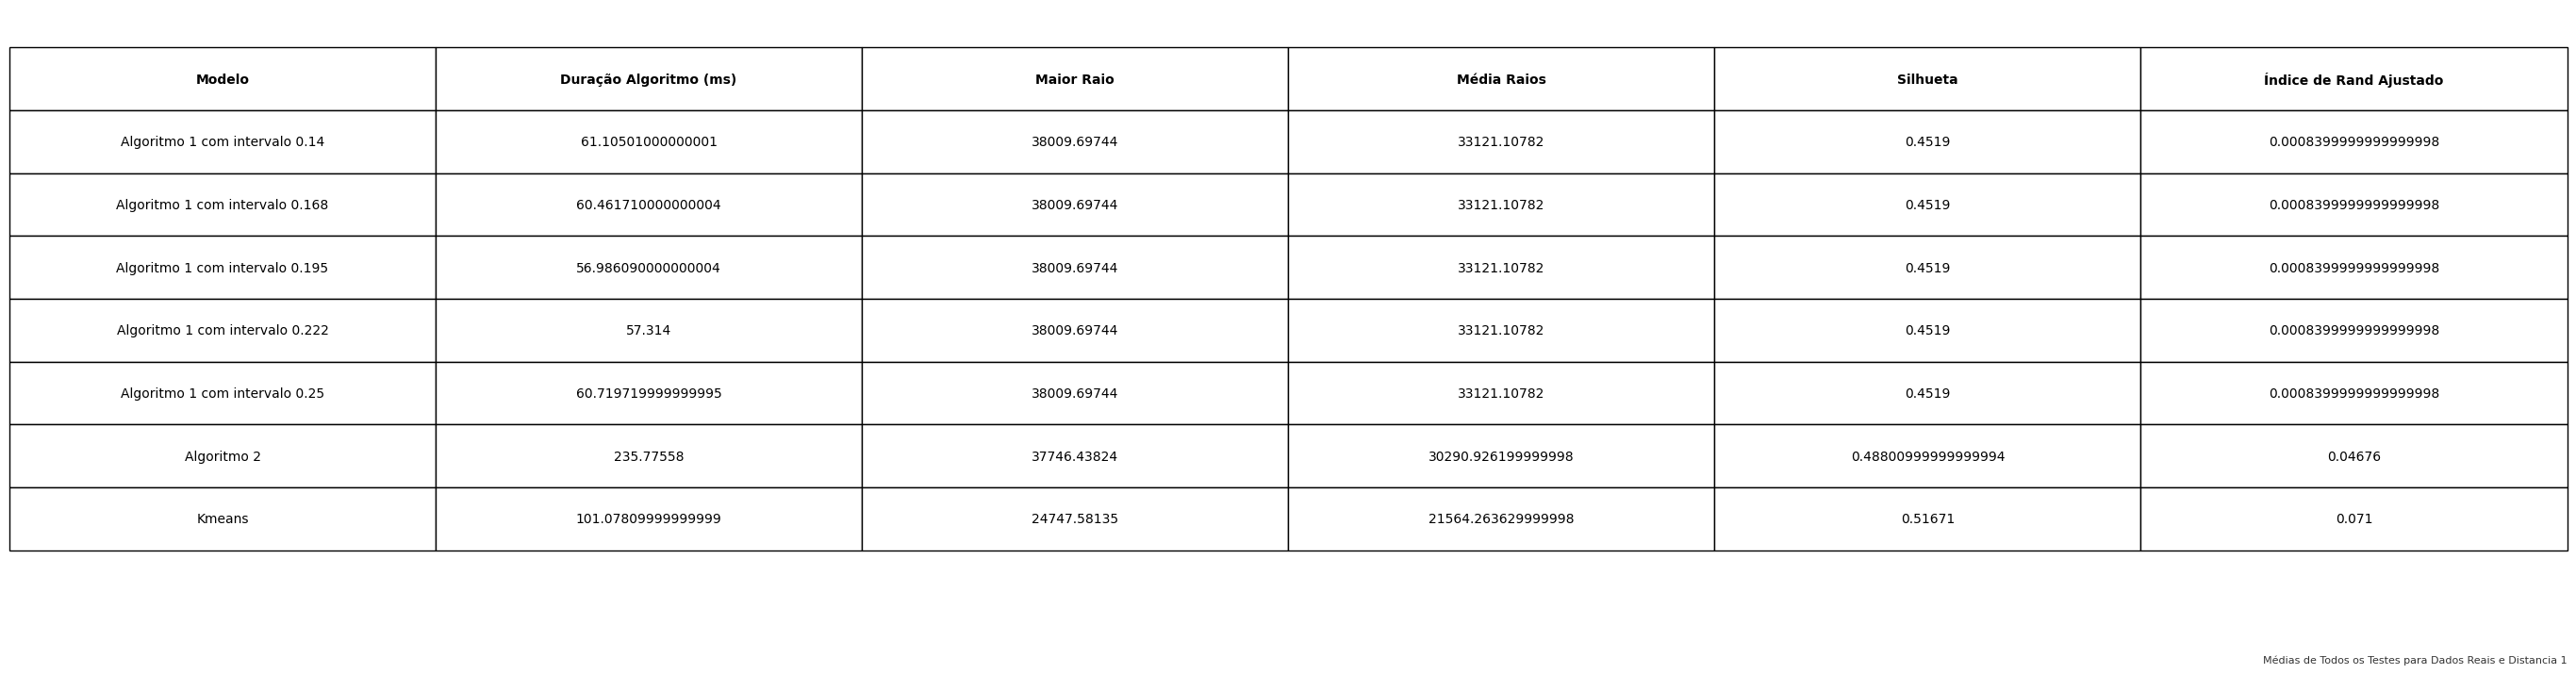

Latex da tabela:
\begin{tabular}{lrrrrr}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 61.105010 & 38009.697440 & 33121.107820 & 0.451900 & 0.000840 \\
Algoritmo 1 com intervalo 0.168 & 60.461710 & 38009.697440 & 33121.107820 & 0.451900 & 0.000840 \\
Algoritmo 1 com intervalo 0.195 & 56.986090 & 38009.697440 & 33121.107820 & 0.451900 & 0.000840 \\
Algoritmo 1 com intervalo 0.222 & 57.314000 & 38009.697440 & 33121.107820 & 0.451900 & 0.000840 \\
Algoritmo 1 com intervalo 0.25 & 60.719720 & 38009.697440 & 33121.107820 & 0.451900 & 0.000840 \\
Algoritmo 2 & 235.775580 & 37746.438240 & 30290.926200 & 0.488010 & 0.046760 \\
Kmeans & 101.078100 & 24747.581350 & 21564.263630 & 0.516710 & 0.071000 \\
\bottomrule
\end{tabular}



In [20]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster,labels in zip(dada_real, names_models_real,qt_clusters_real,labels_list_real):
    labels = labels[0]
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 1, labels, nome_test, n_experimentos)
    
    print(f"Resultados para {title}")
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=names_models_real)
mean_results = combined_df.groupby("Modelo").mean().reset_index()

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias de Todos os Testes para Dados Reais e Distancia 1", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=mean_results.values, colLabels=mean_results.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = mean_results.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)

### Dados Reais com Distancia 2

Resultados para hepatitis


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,62.6196,299944.0522,255827.7516,0.5293,-0.0001
1,Algoritmo 1 com intervalo 0.168,62.3806,299944.0522,255827.7516,0.5293,-0.0001
2,Algoritmo 1 com intervalo 0.195,60.9025,299944.0522,255827.7516,0.5293,-0.0001
3,Algoritmo 1 com intervalo 0.222,73.8536,299944.0522,255827.7516,0.5293,-0.0001
4,Algoritmo 1 com intervalo 0.25,65.7341,299944.0522,255827.7516,0.5293,-0.0001
5,Algoritmo 2,177.5209,297207.7861,221852.4000,0.5275,-0.0006
6,Kmeans,127.4190,160733.4373,150089.6358,0.5774,-0.0013


Resultados para raisin


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,56.1316,77967.0000,71968.0000,0.6431,0.0252
1,Algoritmo 1 com intervalo 0.168,63.2759,77967.0000,71968.0000,0.6431,0.0252
2,Algoritmo 1 com intervalo 0.195,64.8700,77967.0000,71968.0000,0.6431,0.0252
3,Algoritmo 1 com intervalo 0.222,64.3594,77967.0000,71968.0000,0.6431,0.0252
4,Algoritmo 1 com intervalo 0.25,70.7282,77967.0000,71968.0000,0.6431,0.0252
5,Algoritmo 2,108.9895,79171.0000,78170.5000,0.6425,0.0243
6,Kmeans,145.1850,86183.2102,65224.8731,0.6439,0.1756


Resultados para mice_protein


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,72.5592,0.8195,0.4903,0.6237,0.0017
1,Algoritmo 1 com intervalo 0.168,56.8261,0.8195,0.4903,0.6237,0.0017
2,Algoritmo 1 com intervalo 0.195,55.4280,0.8195,0.4903,0.6237,0.0017
3,Algoritmo 1 com intervalo 0.222,54.5627,0.8195,0.4903,0.6237,0.0017
4,Algoritmo 1 com intervalo 0.25,54.5544,0.8195,0.4903,0.6237,0.0017
5,Algoritmo 2,511.0183,0.3588,0.2139,0.5296,0.0764
6,Kmeans,139.5820,0.3890,0.2252,0.4470,0.1091


Resultados para yeast


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,61.3330,0.2138,0.1443,0.1883,-0.0196
1,Algoritmo 1 com intervalo 0.168,56.2460,0.2138,0.1443,0.1883,-0.0196
2,Algoritmo 1 com intervalo 0.195,62.1394,0.2138,0.1443,0.1883,-0.0196
3,Algoritmo 1 com intervalo 0.222,62.5258,0.2138,0.1443,0.1883,-0.0196
4,Algoritmo 1 com intervalo 0.25,50.8739,0.2138,0.1443,0.1883,-0.0196
5,Algoritmo 2,630.0916,0.1980,0.1670,0.1725,0.0362
6,Kmeans,138.0390,0.2697,0.1725,0.3679,0.0620


Resultados para maternal_risk


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,42.1592,20.3961,10.1980,0.8662,-0.0004
1,Algoritmo 1 com intervalo 0.168,39.1101,20.3961,10.1980,0.8662,-0.0004
2,Algoritmo 1 com intervalo 0.195,44.6135,20.3961,10.1980,0.8662,-0.0004
3,Algoritmo 1 com intervalo 0.222,44.6717,20.3961,10.1980,0.8662,-0.0004
4,Algoritmo 1 com intervalo 0.25,46.0705,20.3961,10.1980,0.8662,-0.0004
5,Algoritmo 2,80.3938,10.1980,6.7493,0.4242,0.0008
6,Kmeans,91.4900,60.2134,22.7339,0.6448,0.0192


Resultados para credit


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,66.1352,45.7930,43.2987,0.5866,0.0027
1,Algoritmo 1 com intervalo 0.168,70.0663,45.7930,43.2987,0.5866,0.0027
2,Algoritmo 1 com intervalo 0.195,66.8177,45.7930,43.2987,0.5866,0.0027
3,Algoritmo 1 com intervalo 0.222,55.4241,45.7930,43.2987,0.5866,0.0027
4,Algoritmo 1 com intervalo 0.25,56.9184,45.7930,43.2987,0.5866,0.0027
5,Algoritmo 2,51.1479,41.2311,41.0177,0.4571,0.0615
6,Kmeans,126.6850,50.6941,47.0828,0.3785,-0.0230


Resultados para adult


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,53.1681,18.2483,10.4885,0.3845,-0.0105
1,Algoritmo 1 com intervalo 0.168,63.7758,18.2483,10.4885,0.3845,-0.0105
2,Algoritmo 1 com intervalo 0.195,58.6207,18.2483,10.4885,0.3845,-0.0105
3,Algoritmo 1 com intervalo 0.222,54.6343,18.2483,10.4885,0.3845,-0.0105
4,Algoritmo 1 com intervalo 0.25,59.3561,18.2483,10.4885,0.3845,-0.0105
5,Algoritmo 2,134.3943,19.2094,13.2505,0.4490,0.0079
6,Kmeans,93.1230,25.9737,13.2506,0.4753,0.0171


Resultados para diabetic_retinopathy


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,53.7239,125.0166,116.3504,0.6244,-0.0035
1,Algoritmo 1 com intervalo 0.168,60.3328,125.0166,116.3504,0.6244,-0.0035
2,Algoritmo 1 com intervalo 0.195,59.1103,125.0166,116.3504,0.6244,-0.0035
3,Algoritmo 1 com intervalo 0.222,67.6632,125.0166,116.3504,0.6244,-0.0035
4,Algoritmo 1 com intervalo 0.25,62.5678,125.0166,116.3504,0.6244,-0.0035
5,Algoritmo 2,95.7958,155.3920,148.2071,0.6280,-0.0038
6,Kmeans,62.1740,180.5887,146.1981,0.5837,-0.0022


Resultados para dry_beans


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,66.1000,312.7150,227.3100,0.1882,0.0109
1,Algoritmo 1 com intervalo 0.168,66.4927,312.7150,227.3100,0.1882,0.0109
2,Algoritmo 1 com intervalo 0.195,63.9852,312.7150,227.3100,0.1882,0.0109
3,Algoritmo 1 com intervalo 0.222,65.7294,312.7150,227.3100,0.1882,0.0109
4,Algoritmo 1 com intervalo 0.25,62.0431,312.7150,227.3100,0.1882,0.0109
5,Algoritmo 2,356.6096,119.8320,93.8839,0.4684,0.2984
6,Kmeans,146.4390,240.6042,98.3250,0.5489,0.3510


Resultados para wine_quality


,Modelo,Duração Algoritmo (ms),Maior Raio,Média Raios,Silhueta,Índice de Rand Ajustado
0,Algoritmo 1 com intervalo 0.14,54.5242,0.2901,0.1500,0.4996,0.0051
1,Algoritmo 1 com intervalo 0.168,57.9957,0.2901,0.1500,0.4996,0.0051
2,Algoritmo 1 com intervalo 0.195,60.8256,0.2901,0.1500,0.4996,0.0051
3,Algoritmo 1 com intervalo 0.222,57.1817,0.2901,0.1500,0.4996,0.0051
4,Algoritmo 1 com intervalo 0.25,74.5499,0.2901,0.1500,0.4996,0.0051
5,Algoritmo 2,341.7829,0.1202,0.0934,0.4675,0.0069
6,Kmeans,22.9680,0.4332,0.1393,0.4997,0.0025


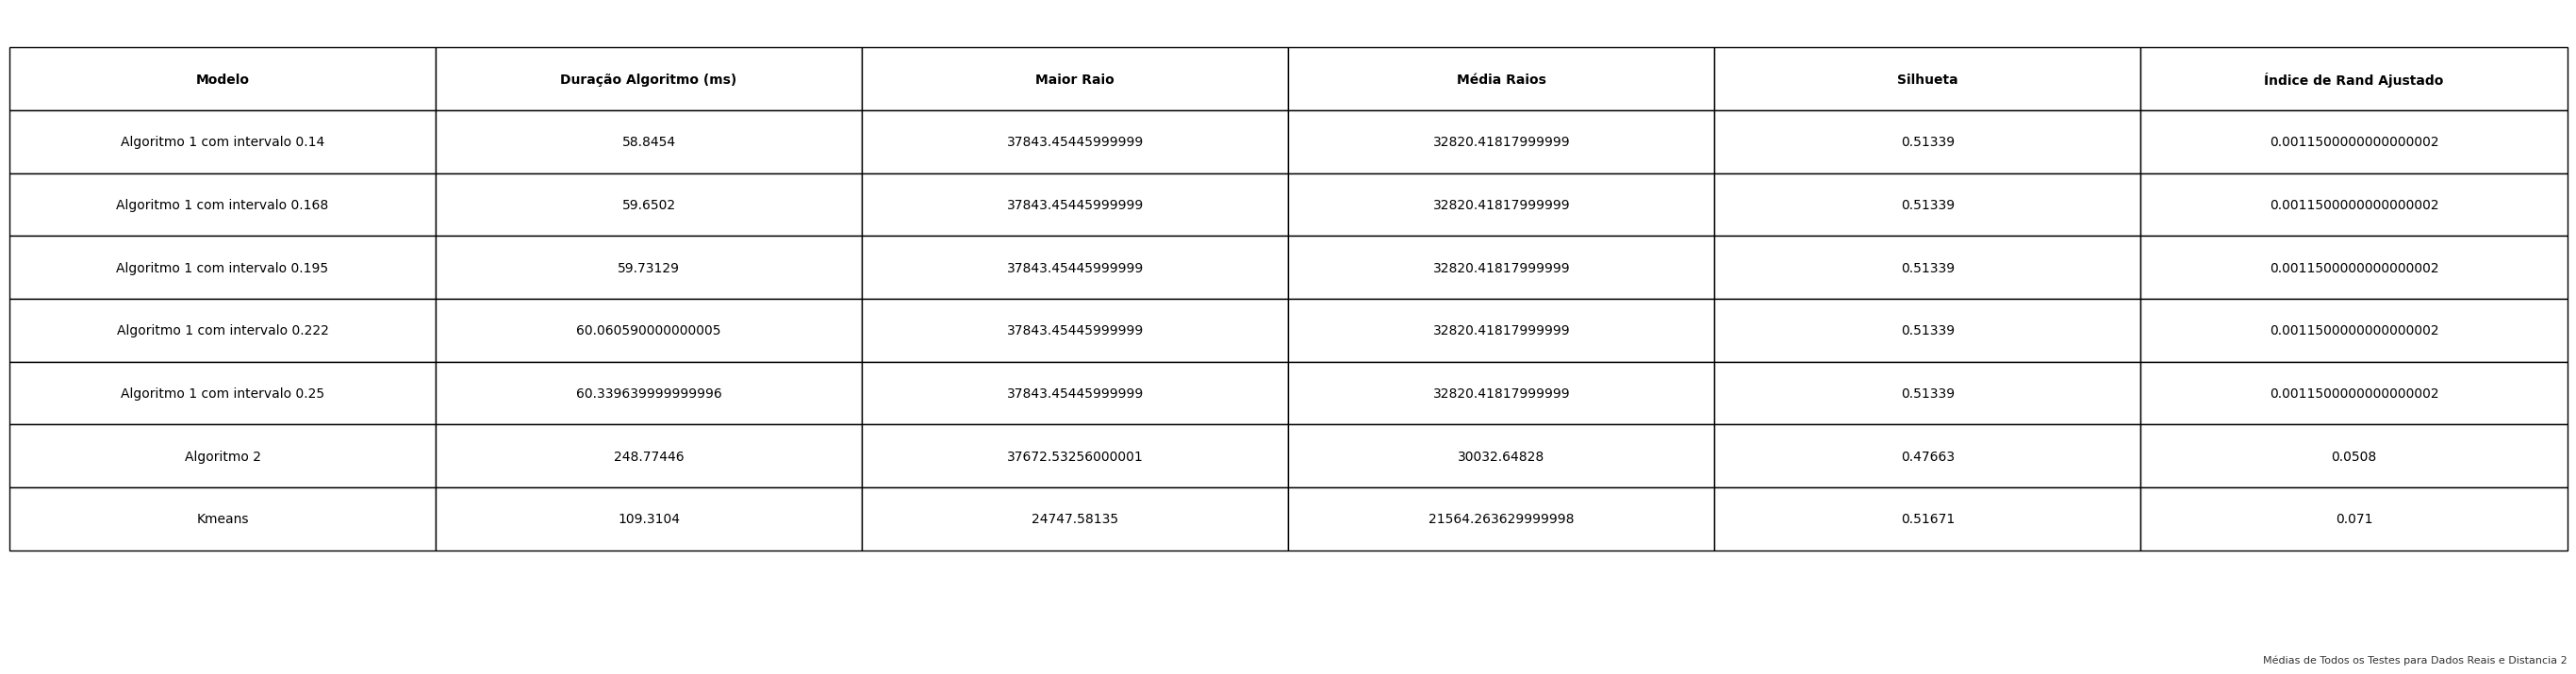

Latex da tabela:
\begin{tabular}{lrrrrr}
\toprule
Modelo & Duração Algoritmo (ms) & Maior Raio & Média Raios & Silhueta & Índice de Rand Ajustado \\
\midrule
Algoritmo 1 com intervalo 0.14 & 58.845400 & 37843.454460 & 32820.418180 & 0.513390 & 0.001150 \\
Algoritmo 1 com intervalo 0.168 & 59.650200 & 37843.454460 & 32820.418180 & 0.513390 & 0.001150 \\
Algoritmo 1 com intervalo 0.195 & 59.731290 & 37843.454460 & 32820.418180 & 0.513390 & 0.001150 \\
Algoritmo 1 com intervalo 0.222 & 60.060590 & 37843.454460 & 32820.418180 & 0.513390 & 0.001150 \\
Algoritmo 1 com intervalo 0.25 & 60.339640 & 37843.454460 & 32820.418180 & 0.513390 & 0.001150 \\
Algoritmo 2 & 248.774460 & 37672.532560 & 30032.648280 & 0.476630 & 0.050800 \\
Kmeans & 109.310400 & 24747.581350 & 21564.263630 & 0.516710 & 0.071000 \\
\bottomrule
\end{tabular}



In [21]:
n_experimentos = 30

combined_results = []

for data, title, k_cluster,labels in zip(dada_real, names_models_real,qt_clusters_real,labels_list_real):
    labels = labels[0]
    nome_test = f"Resultados para {title}"

    df_resultado = executeAll(np.array(data[0]), k_cluster, 2, labels, nome_test, n_experimentos)
    
    print(f"Resultados para {title}")
    display(df_resultado)
    
    combined_results.append(df_resultado)
    
combined_df = pd.concat(combined_results, keys=names_models_real)
mean_results = combined_df.groupby("Modelo").mean().reset_index()

fig, ax = plt.subplots(figsize=(35, 8))
ax.axis('tight')
ax.axis('off')

fig.text(0.90, 0.01, f"Médias de Todos os Testes para Dados Reais e Distancia 2", fontsize=8, ha='right', va='bottom', alpha=0.8)

table = ax.table(cellText=mean_results.values, colLabels=mean_results.columns, cellLoc='center', loc='center')
table.scale(1, 4)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold')

latex_code = mean_results.to_latex(index=False)

plt.show()
print("Latex da tabela:")
print(latex_code)